# ML-Based Marketing

Руководитель: [Лукьянченко Пётр Павлович](https://www.hse.ru/staff/lukianchenko)

Студенты: [Гончаров Фёдор Михайлович](http://t.me/fmgoncharov), [Писцов Георгий Константинович](http://t.me/GoshaNice)

Материалы:
- [КТ1](https://drive.google.com/file/d/1X9sN0MSib5yEGM-PElc6Y33UsGcLC2Nz/view?usp=share_link)
- [CausalML](https://github.com/uber/causalml)
- [EconlML](https://github.com/py-why/EconML)

## Первичная подготовка данных

Импортируем все необходимые библиотеки

In [1]:
from IPython.display import display
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import csv

Загружаем датасеты за 3 месяца

In [2]:
jan2feb = pd.read_csv('jan2feb.csv', sep=';', parse_dates=['Дата'], dayfirst=True).iloc[::-1]
feb2mar = pd.read_csv('feb2mar.csv', sep=';', parse_dates=['Дата'], dayfirst=True).iloc[::-1]
mar2apr = pd.read_csv('mar2apr.csv', sep=';', parse_dates=['Дата'], dayfirst=True).iloc[::-1]

Объединяем три месяца в один датасет, выставляем даты транзакций как индексы, убираем колонку с уникальными номерами заказов

In [3]:
df = pd.concat([jan2feb, feb2mar, mar2apr], ignore_index=True, verify_integrity=True)
df.rename(columns={"Дата": "Date", "Профиль участника": "UID", "Вид операции": "OperationType", "Сумма": "Price", "Сумма списанных монет": "SpentCoins", "Сумма начисленных монет": "GainedCoins", "Ресторан": "Point", "Агент продаж": "Agent", "Статус": "Status"}, inplace=True)
df.set_index('Date', inplace=True)
df.drop(columns=['Номер'], inplace=True)
df.head()

,UID,OperationType,Price,SpentCoins,GainedCoins,Point,Agent,Status
Date,,,,,,,,
2023-01-15 00:06:45,37704f27-3e29-11eb-80c2-00155d01af05,Покупка,127.0,37.0,2.54,Р АЭРОПОРТ,Касса,Бронзовый ключ
2023-01-15 00:12:34,0ca8729c-f364-11ea-80e4-f403435823a3,Покупка,105.0,NaN,2.10,Р АЭРОПОРТ,Касса,Бронзовый ключ
2023-01-15 00:22:00,b152cb7e-de6e-11ec-80dc-00155dd23e20,Покупка,551.0,9.0,16.53,Р АЭРОПОРТ,Касса,Серебряный ключ
2023-01-15 00:34:51,0ca8729c-f364-11ea-80e4-f403435823a3,Покупка,113.0,NaN,2.26,Р АЭРОПОРТ,Касса,Бронзовый ключ
2023-01-15 00:36:00,b152cb7e-de6e-11ec-80dc-00155dd23e20,Покупка,280.0,NaN,8.40,Р АЭРОПОРТ,Касса,Серебряный ключ


In [4]:
day_of_week_labels = ['Понедельник', 'Вторник', 'Среда', 'Четверг', 'Пятница', 'Суббота', 'Воскресенье']
months_labels = ['Январь', 'Февраль', 'Май', 'Апрель', 'Май', 'Июнь', 'Июль', 'Август', 'Сентябрь', 'Октябрь', 'Ноябрь', 'Декабрь']
assert(len(day_of_week_labels) == 7 and len(months_labels) == 12)

start_dt, end_dt = df.iloc[0].name, df.iloc[-1].name
print(f'Датасет начинается {start_dt.day} {months_labels[start_dt.month-1][:-1]}я и заканчивается {end_dt.day} {months_labels[end_dt.month-1][:-1]}я включительно')

Датасет начинается 15 Января и заканчивается 14 Апреля включительно


Проверяем размер данных

In [5]:
m, n = df.shape
numerical = ['Price', 'SpentCoins', 'GainedCoins', 'ActualPrice']
categorical = ['OperationType', 'Point', 'Agent', 'Status']
print(f"В датасете {m} строк и {n} столбцов")
print(f"Из них {len(numerical)} численных и {len(categorical)} категориальных")
assert(len(numerical) + len(categorical) == n)

В датасете 2267437 строк и 8 столбцов
Из них 4 численных и 4 категориальных


Заполняем пропуски по потраченным и начисленным монетам. Делаем колонку по процент накопления монет по статусу

In [6]:
cols_with_nans = []
for col in df:
    if df[col].isna().sum() > 0:
        cols_with_nans.append(col)
        df[col].fillna(0, inplace=True)
print("Найдены пропуски в колонках", *cols_with_nans)
print("Пропуски заполнены нулями")

df['Discount'] = df['Status'].replace({"Бронзовый ключ": 0.02, "Серебряный ключ": 0.03, "Золотой ключ": 0.05, "Платиновый ключ": 0.07, "Сотрудник": 0.15})

Найдены пропуски в колонках SpentCoins GainedCoins
Пропуски заполнены нулями


In [7]:
assert(len(df.groupby('UID')['Status'].nunique().unique()) > 1)
print("Статусы соответсвуют дню совершения транзакции")

Статусы соответсвуют дню совершения транзакции


## Анализ данных. Построение графиков

Исследуем корреляционную матрицу численных переменных датасета. Колонки Price и GainedCoins ожидаемо имеют высокую корелляцию

/var/folders/mr/qh1d74xx1879g41tnvr1g9j00000gn/T/ipykernel_1795/2700590646.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


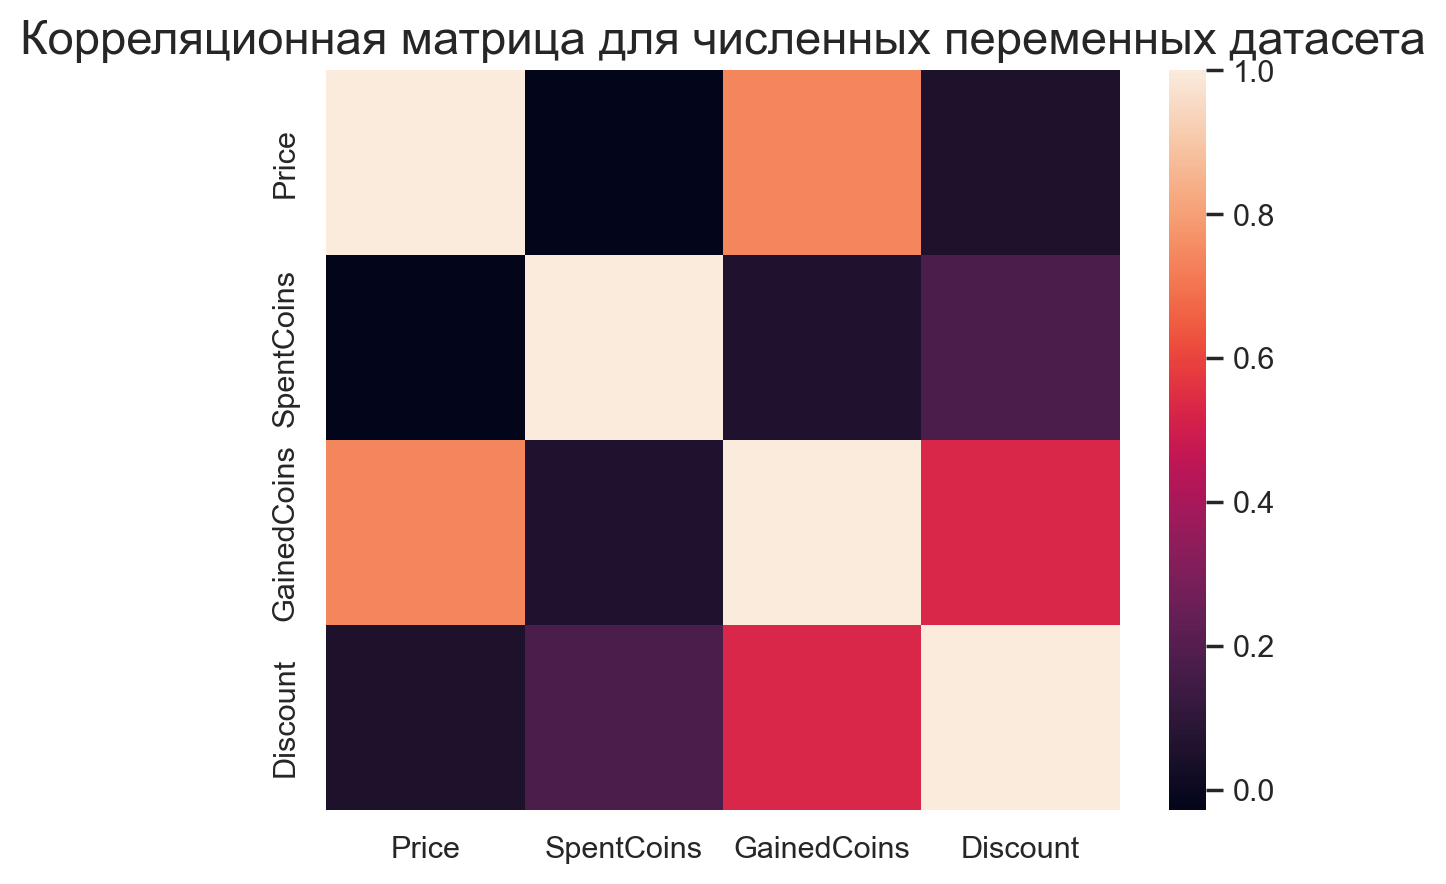

In [8]:
corr = df.corr()
sns.set_theme()
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns)
plt.title('Корреляционная матрица для численных переменных датасета', fontsize=17)
plt.show()

Добавляем технические переменные о датах совершения транзакции

In [9]:
df['DayOfWeek'] = df.index.dayofweek
df['Month'] = df.index.month
df['Hour'] = df.index.hour
df['DayOfYear'] = df.index.dayofyear

Исследуем остальные данные о транзакциях

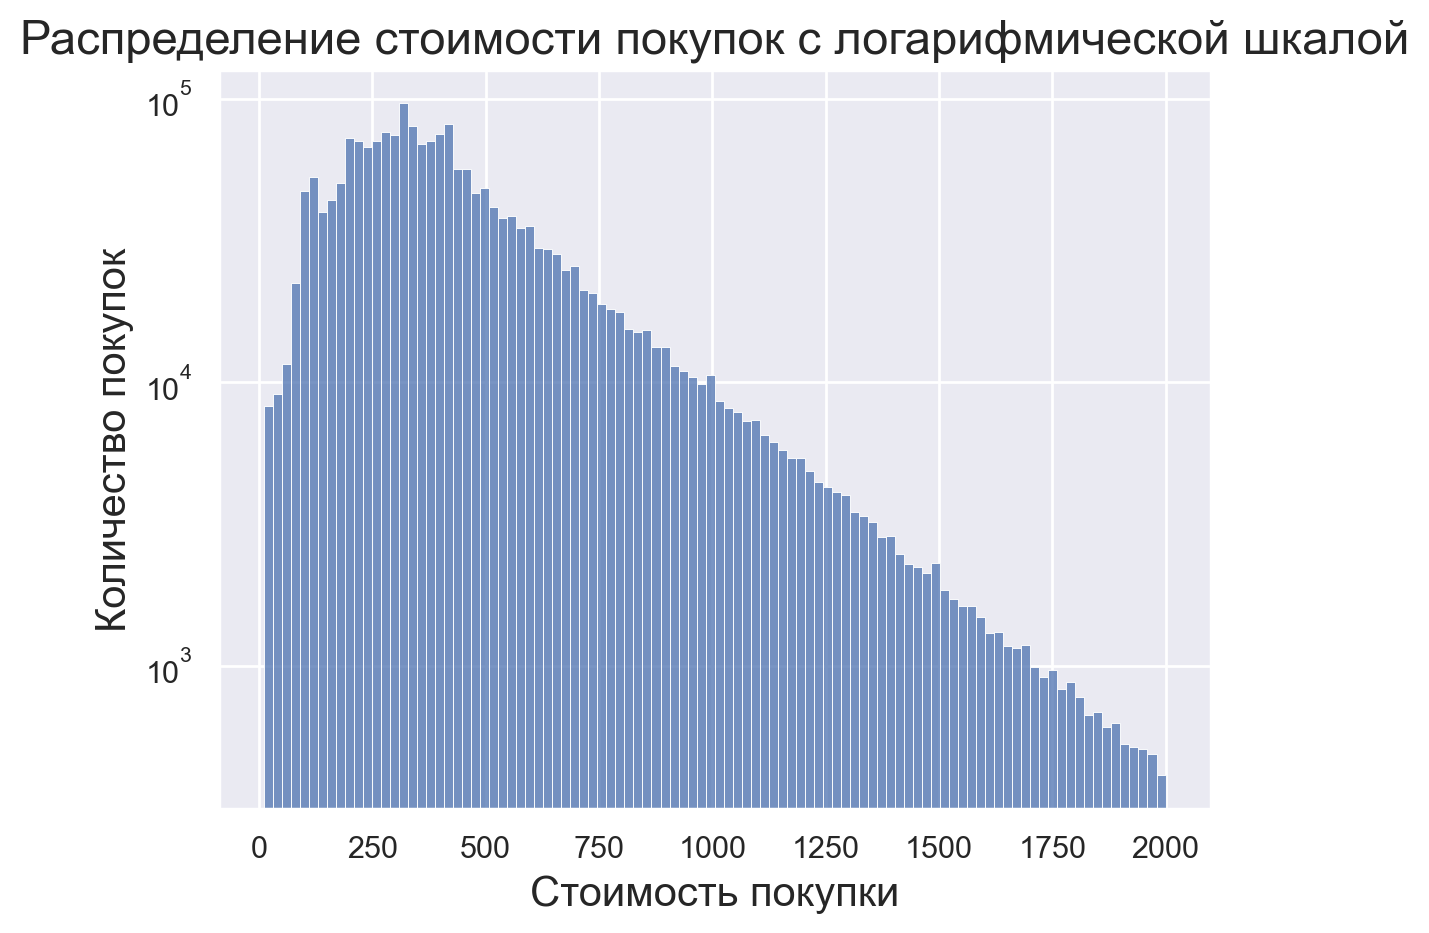

In [10]:
sns.histplot(df[(df['Price'] > 10) & (df['Price'] < 2000)]['Price'], bins=100)
plt.title('Распределение стоимости покупок с логарифмической шкалой', fontsize=17)
plt.xlabel('Стоимость покупки', fontsize=15)
plt.ylabel('Количество покупок', fontsize=15)
plt.yscale('log')
plt.show()

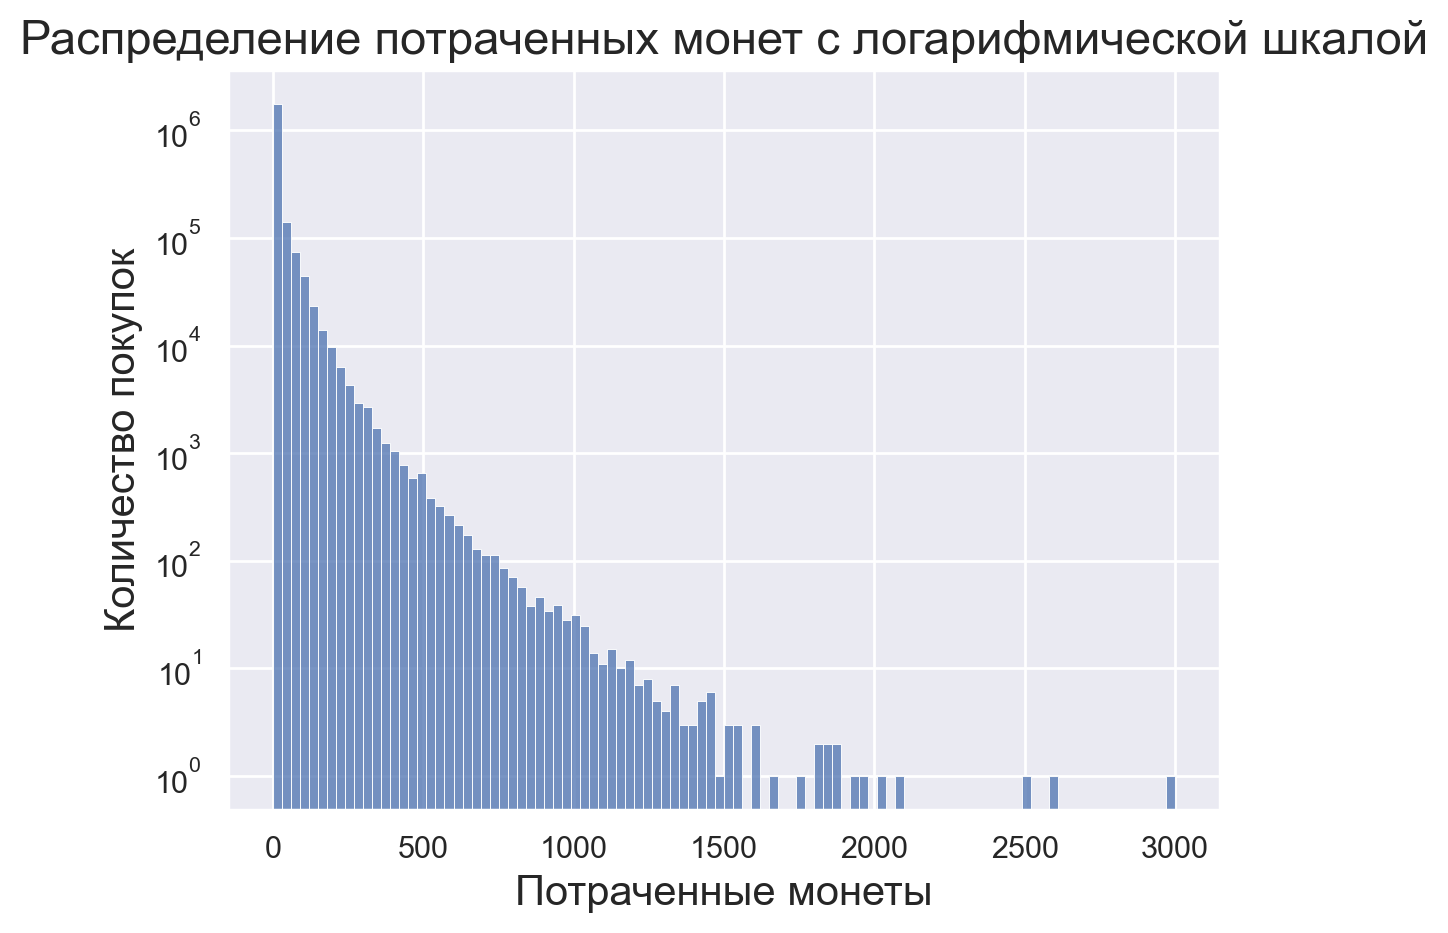

In [11]:
sns.histplot(df[(df['Price'] > 10) & (df['Price'] < 2000) & (df['SpentCoins'] >= 0)]['SpentCoins'], bins=100)
plt.title('Распределение потраченных монет с логарифмической шкалой', fontsize=17)
plt.xlabel('Потраченные монеты', fontsize=15)
plt.ylabel('Количество покупок', fontsize=15)
plt.yscale('log')
plt.show()

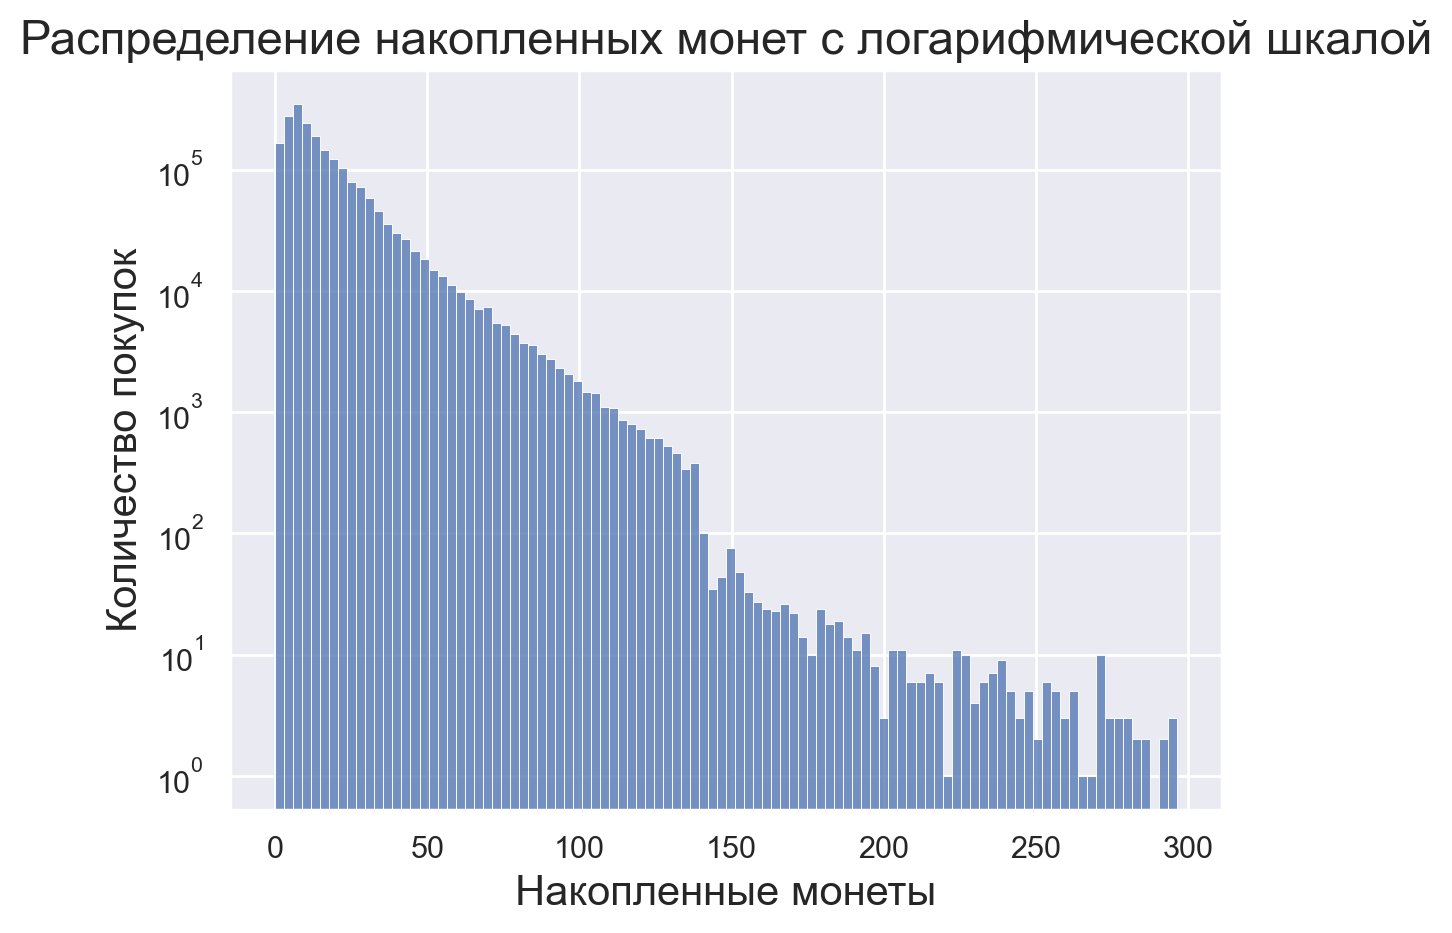

In [12]:
sns.histplot(df[(df['Price'] > 10) & (df['Price'] < 2000) & (df['GainedCoins'] >= 0)]['GainedCoins'], bins=100)
plt.title('Распределение накопленных монет с логарифмической шкалой', fontsize=17)
plt.xlabel('Накопленные монеты', fontsize=15)
plt.ylabel('Количество покупок', fontsize=15)
plt.yscale('log')
plt.show()

## Поправить график и посмотреть не только по транзакциям, но и по клиентам

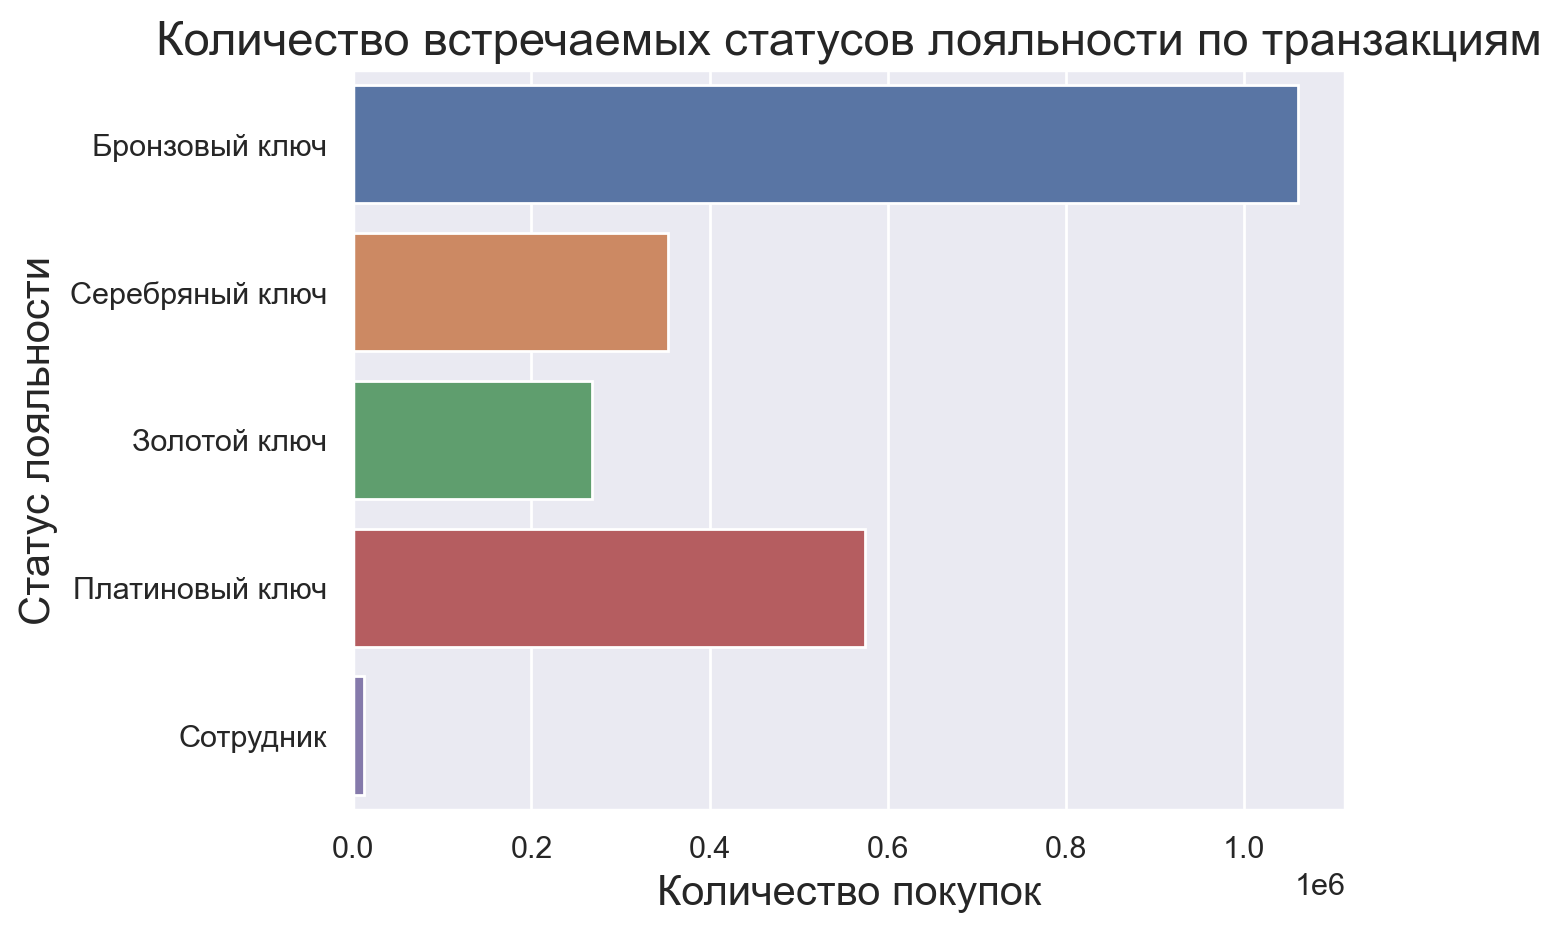

In [13]:
sns.countplot(data=df, y='Status', order=['Бронзовый ключ', 'Серебряный ключ', 'Золотой ключ', 
       'Платиновый ключ', 'Сотрудник'])
plt.title('Количество встречаемых статусов лояльности по транзакциям', fontsize=17)
plt.xlabel('Количество покупок', fontsize=15)
plt.ylabel('Статус лояльности', fontsize=15)
plt.show()

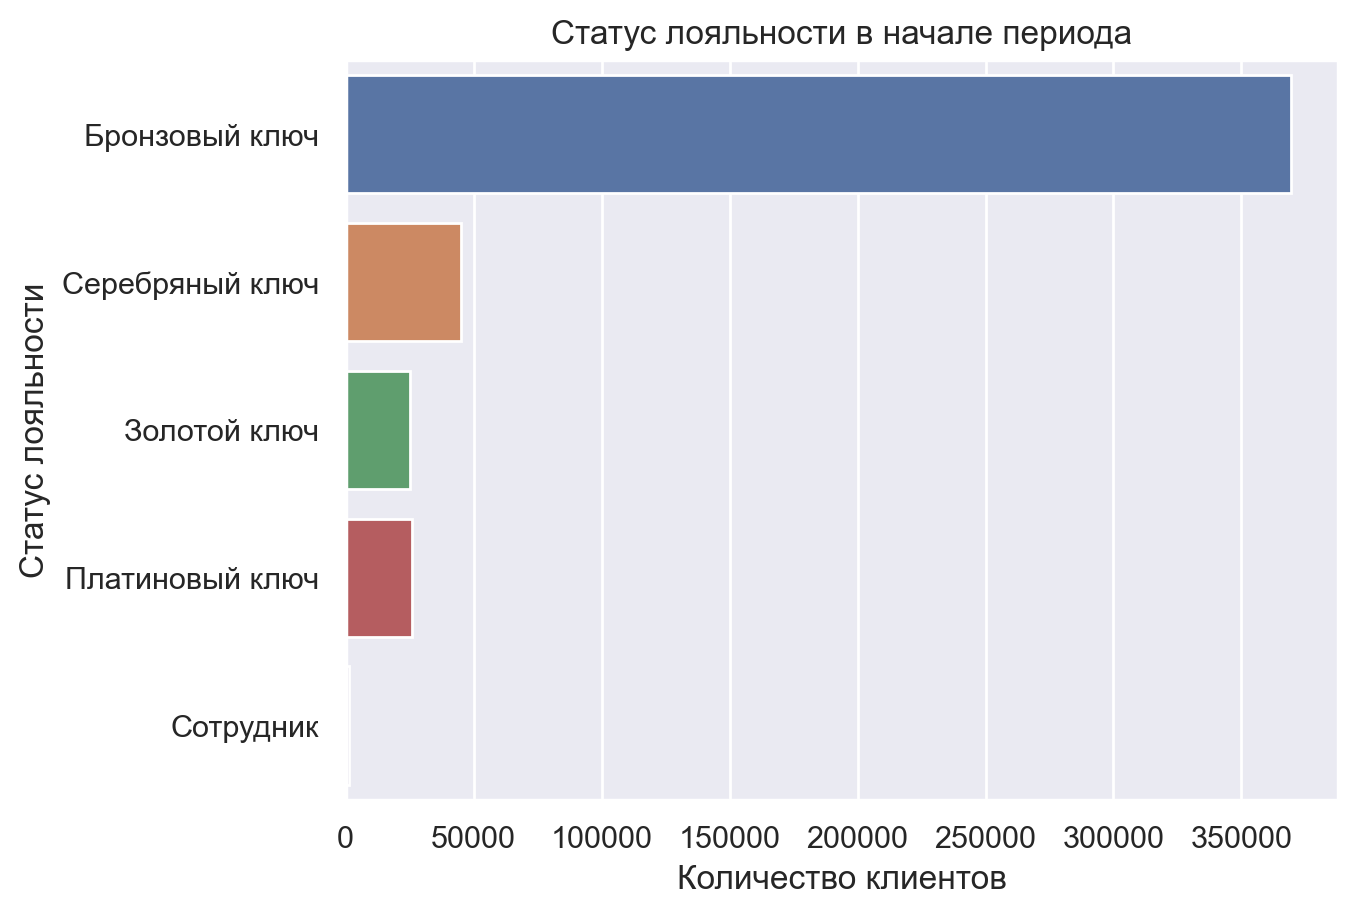

In [14]:
sns.countplot(order=['Бронзовый ключ', 'Серебряный ключ', 'Золотой ключ', 
       'Платиновый ключ', 'Сотрудник'], y='Status', data=df.groupby('UID').Status.first().to_frame())
plt.title('Статус лояльности в начале периода')
plt.xlabel("Количество клиентов")
plt.ylabel("Статус лояльности")
plt.show()

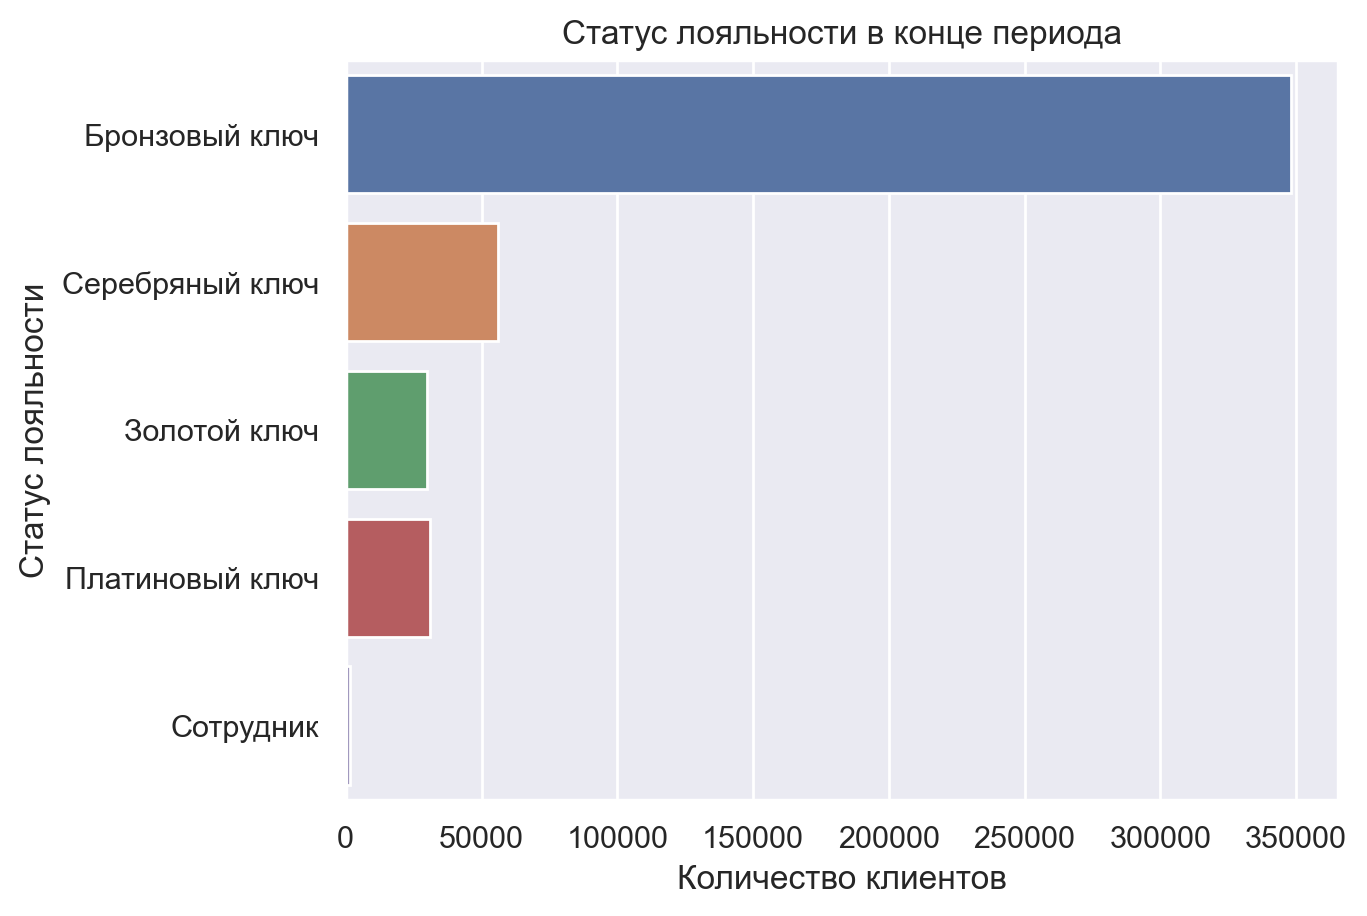

In [15]:
sns.countplot(order=['Бронзовый ключ', 'Серебряный ключ', 'Золотой ключ', 
       'Платиновый ключ', 'Сотрудник'], y='Status', data=df.groupby('UID').Status.last().to_frame())
plt.title('Статус лояльности в конце периода')
plt.xlabel("Количество клиентов")
plt.ylabel("Статус лояльности")
plt.show()

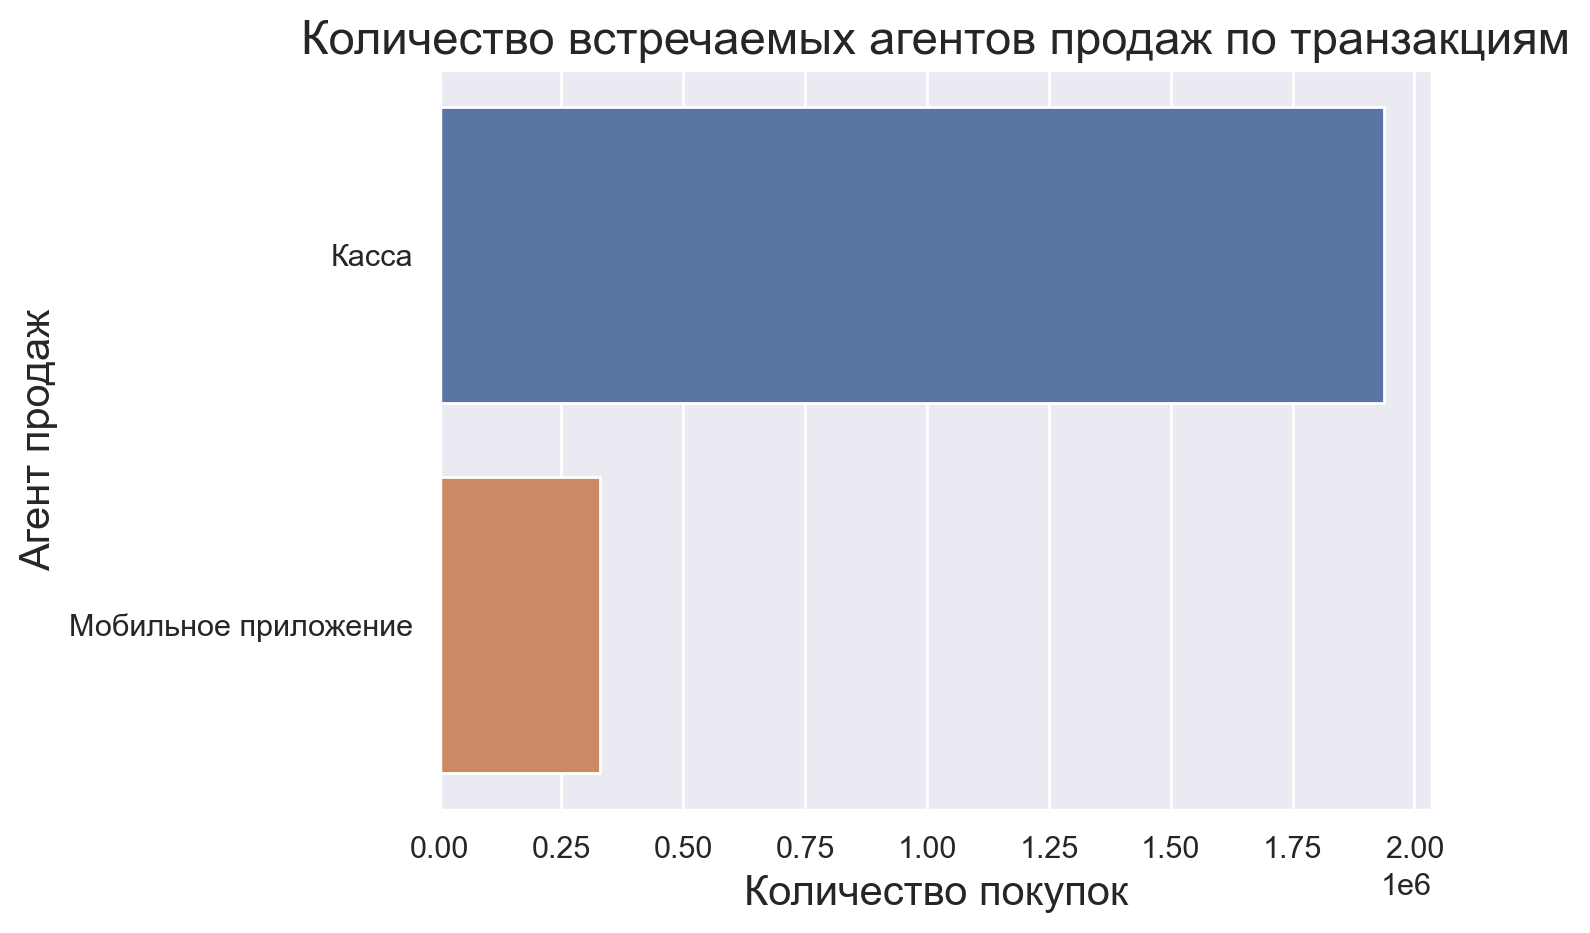

In [16]:
sns.countplot(data=df, y='Agent')
plt.title('Количество встречаемых агентов продаж по транзакциям', fontsize=17)
plt.xlabel('Количество покупок', fontsize=15)
plt.ylabel('Агент продаж', fontsize=15)
plt.show()

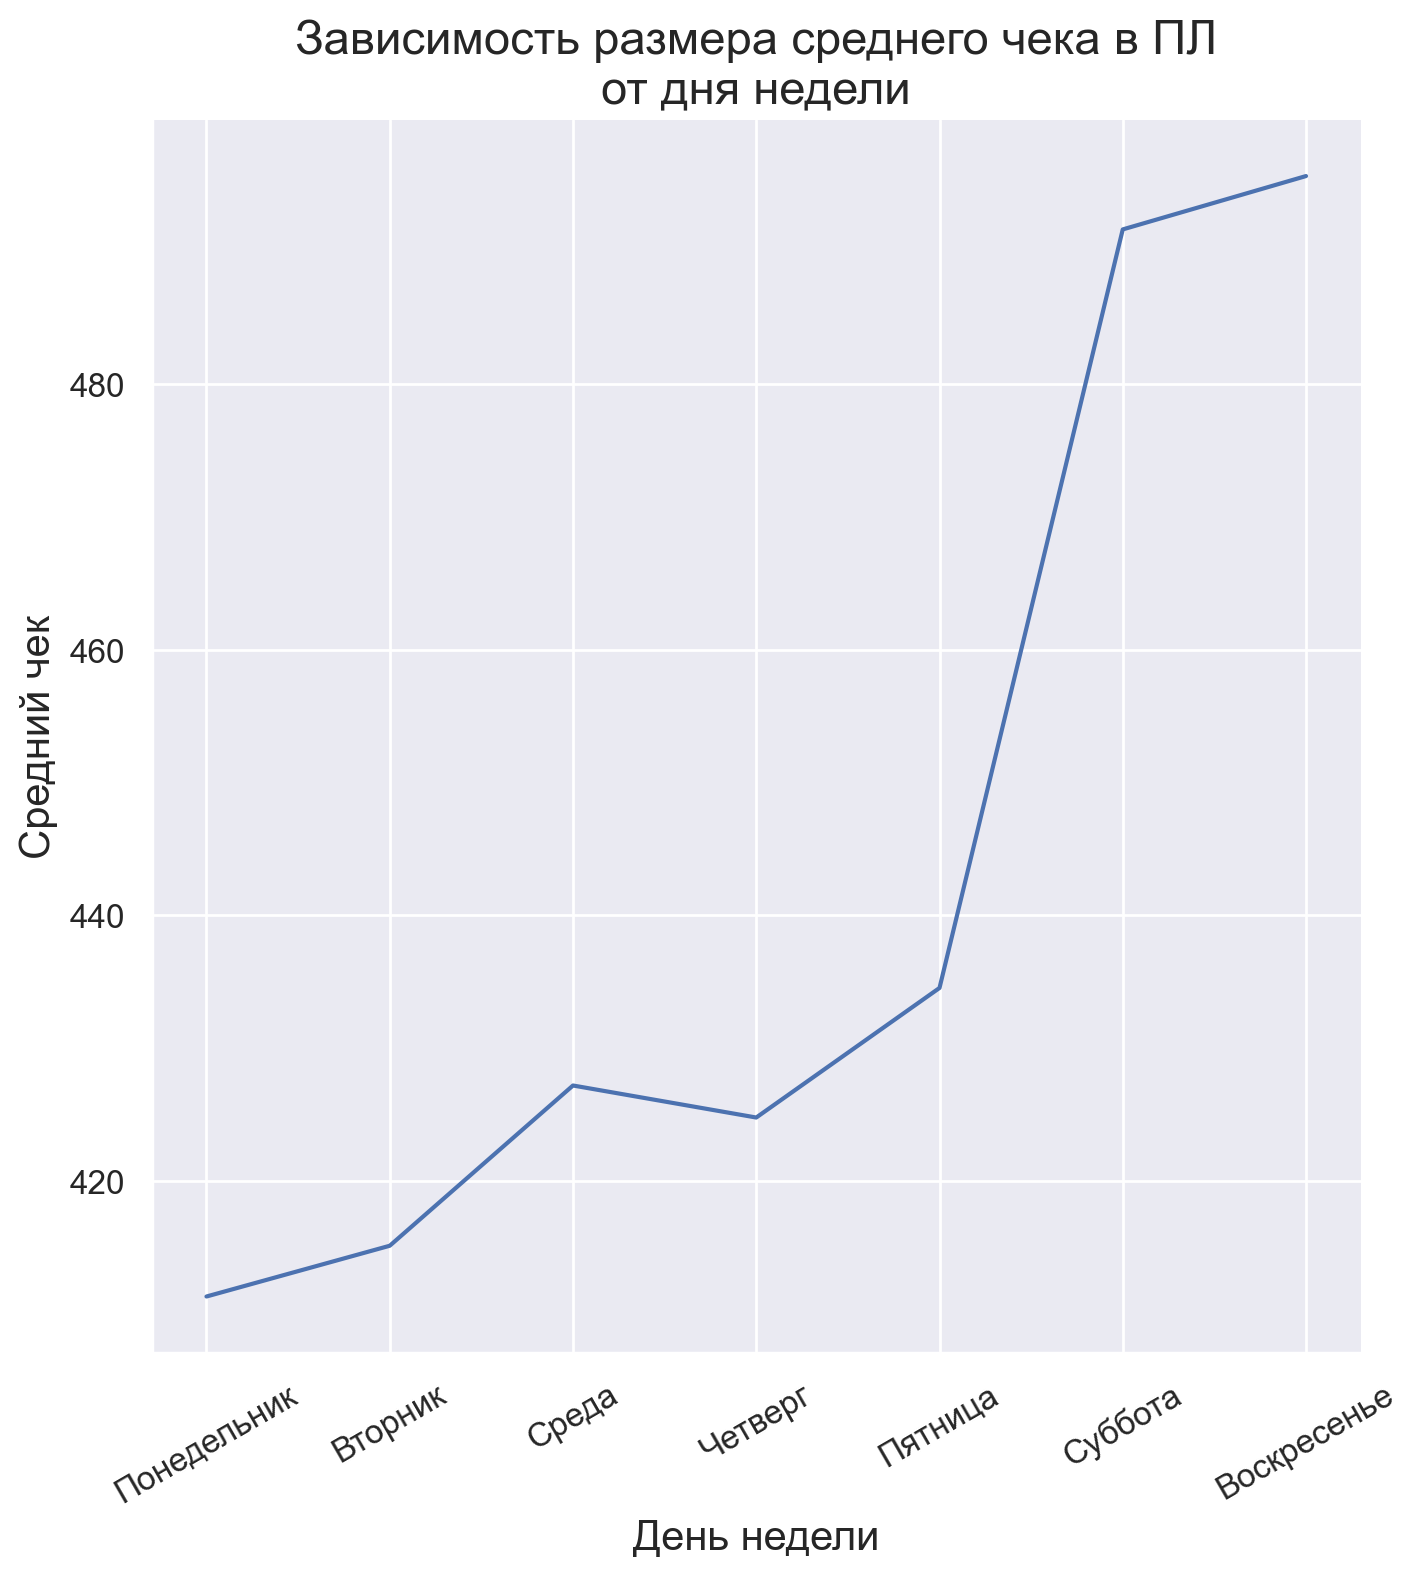

In [17]:
sns.relplot(df.groupby('DayOfWeek').Price.mean(), kind='line', height=7)
plt.title('Зависимость размера среднего чека в ПЛ\nот дня недели', fontsize=17)
plt.xlabel('День недели', fontsize=15)
plt.ylabel('Средний чек', fontsize=15)
plt.xticks(np.arange(7),
           labels=day_of_week_labels,
           fontsize=12,
           rotation=30)
plt.yticks(fontsize=12)
plt.show()

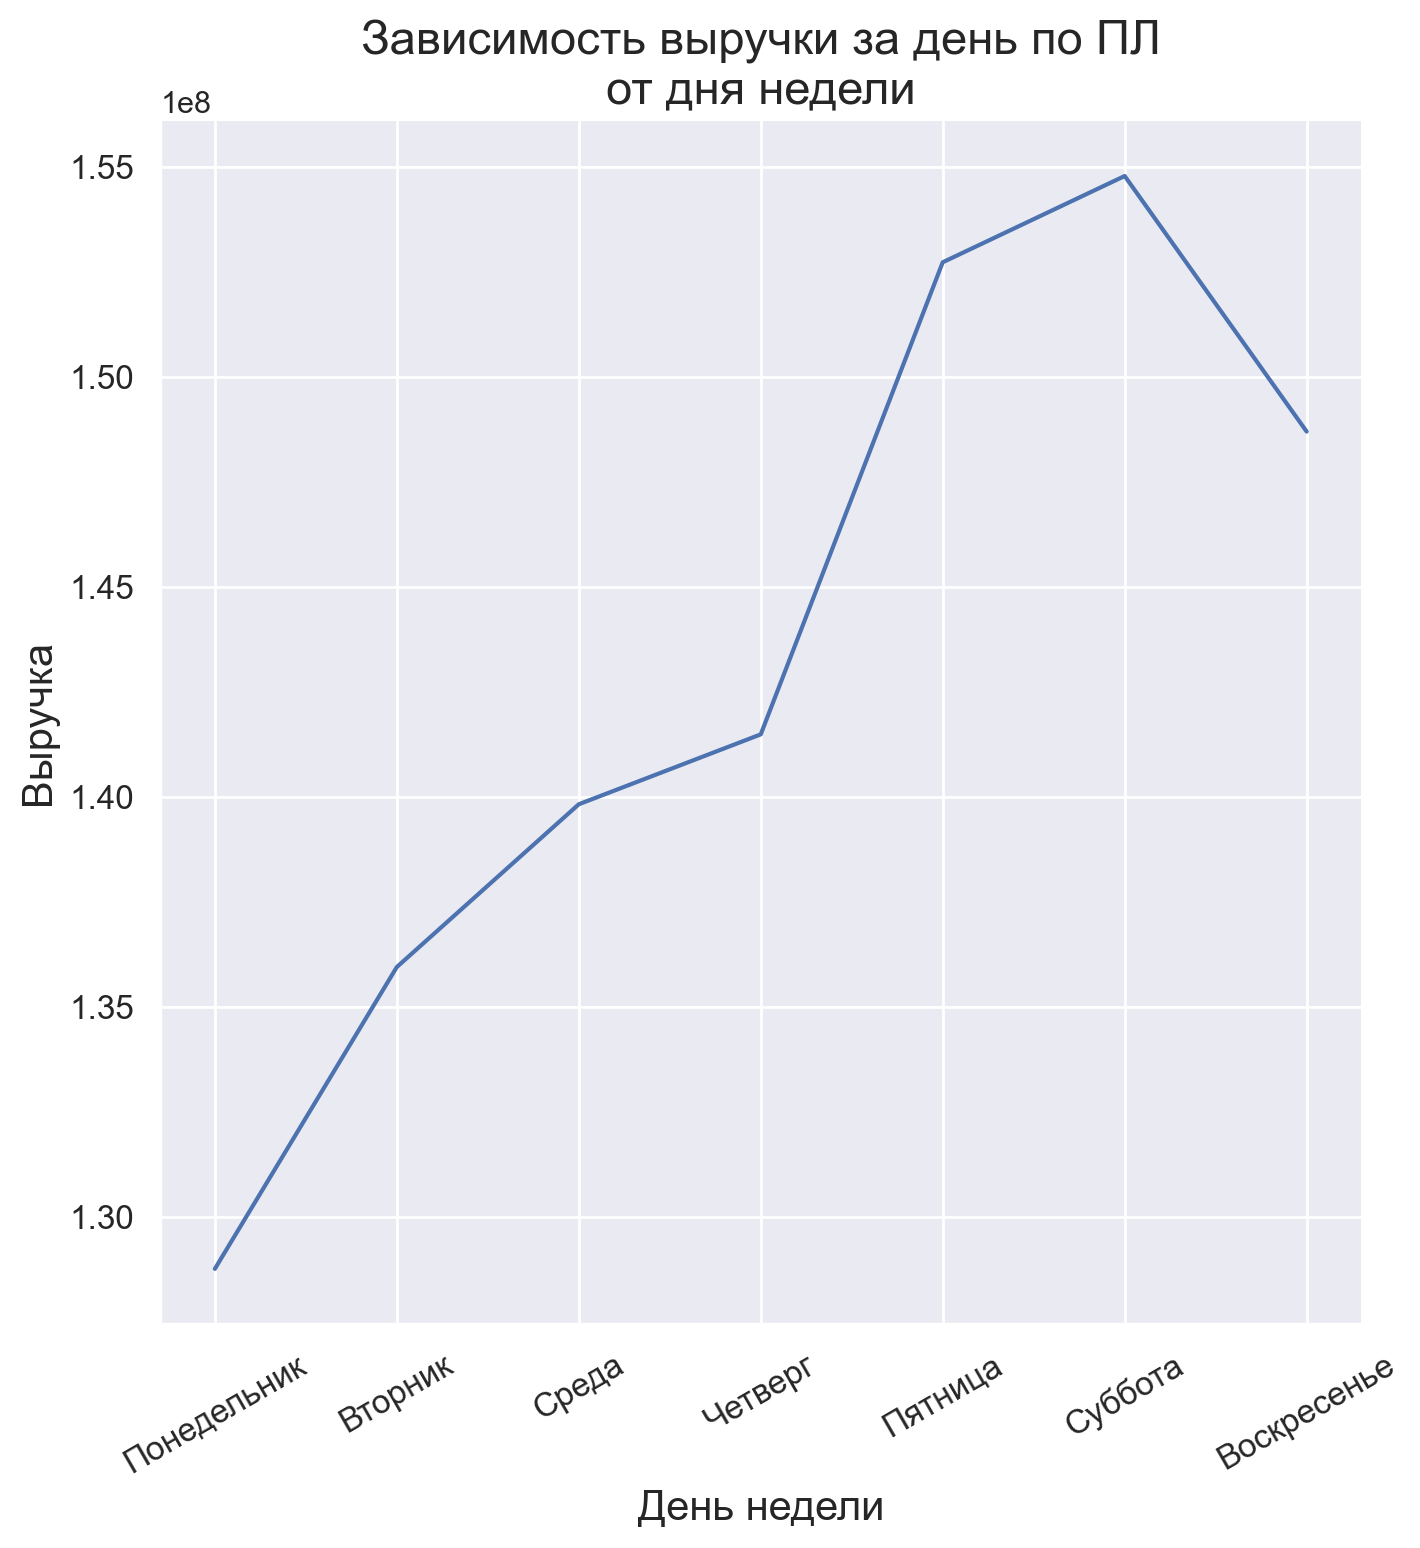

In [18]:
sns.relplot(df.groupby('DayOfWeek').Price.sum(), kind='line', height=7)
plt.title('Зависимость выручки за день по ПЛ\nот дня недели', fontsize=17)
plt.xlabel('День недели', fontsize=15)
plt.ylabel('Выручка', fontsize=15)
plt.xticks(np.arange(7),
           labels=day_of_week_labels,
           fontsize=12,
           rotation=30)
plt.yticks(fontsize=12)
plt.show()

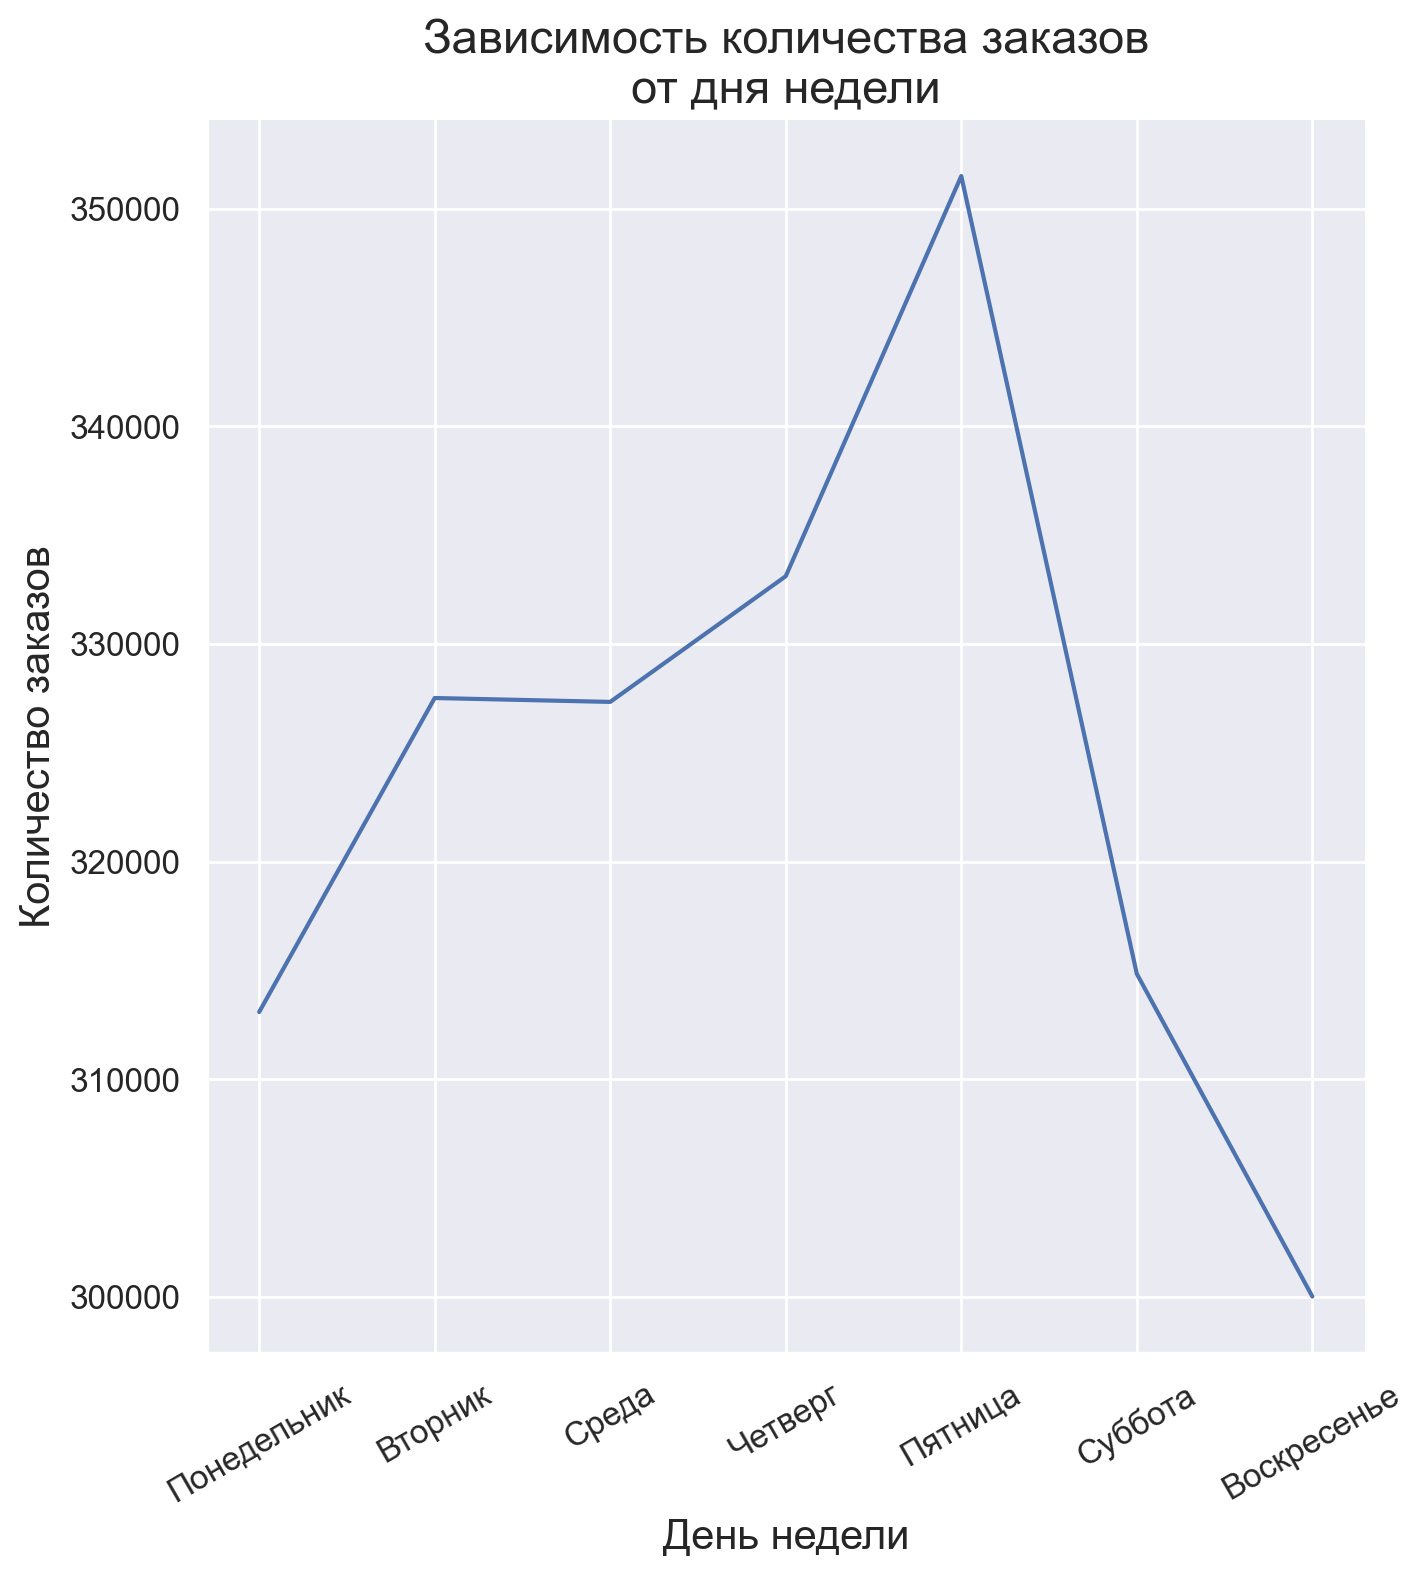

In [19]:
sns.relplot(df.groupby('DayOfWeek').UID.count(), kind='line', height=7)
plt.title('Зависимость количества заказов\nот дня недели', fontsize=17)
plt.xlabel('День недели', fontsize=15)
plt.ylabel('Количество заказов', fontsize=15)
plt.xticks(np.arange(7),
           labels=day_of_week_labels,
           fontsize=12,
           rotation=30)
plt.yticks(fontsize=12)
plt.show()

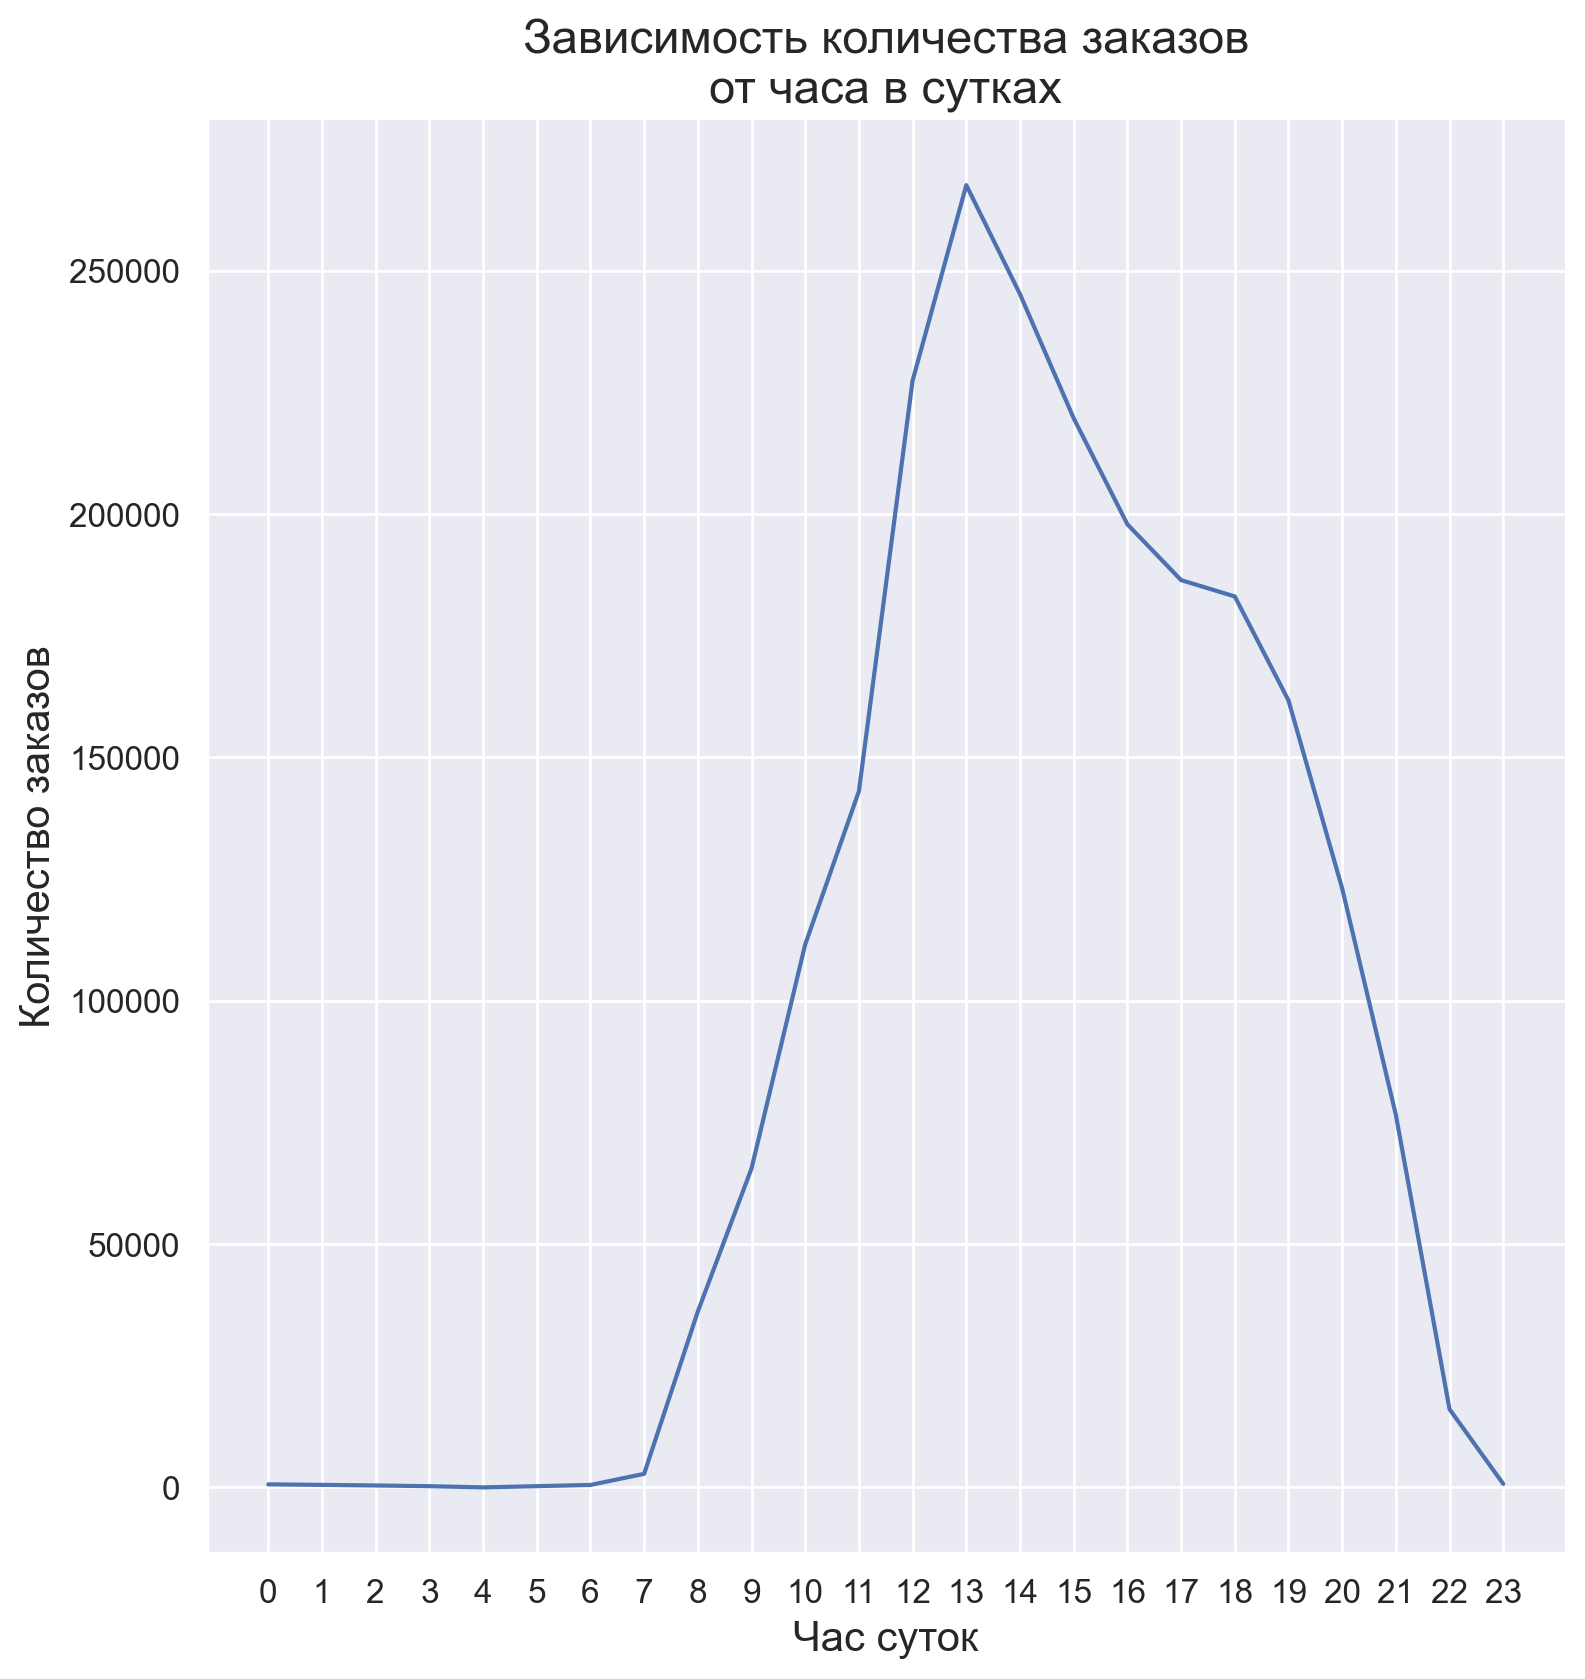

In [20]:
sns.relplot(df.groupby('Hour').UID.count(), kind='line', height=8)
plt.title('Зависимость количества заказов\nот часа в сутках', fontsize=17)
plt.xlabel('Час суток', fontsize=15)
plt.ylabel('Количество заказов', fontsize=15)
plt.xticks(np.arange(24), fontsize=12)
plt.yticks(fontsize=12)
plt.show()

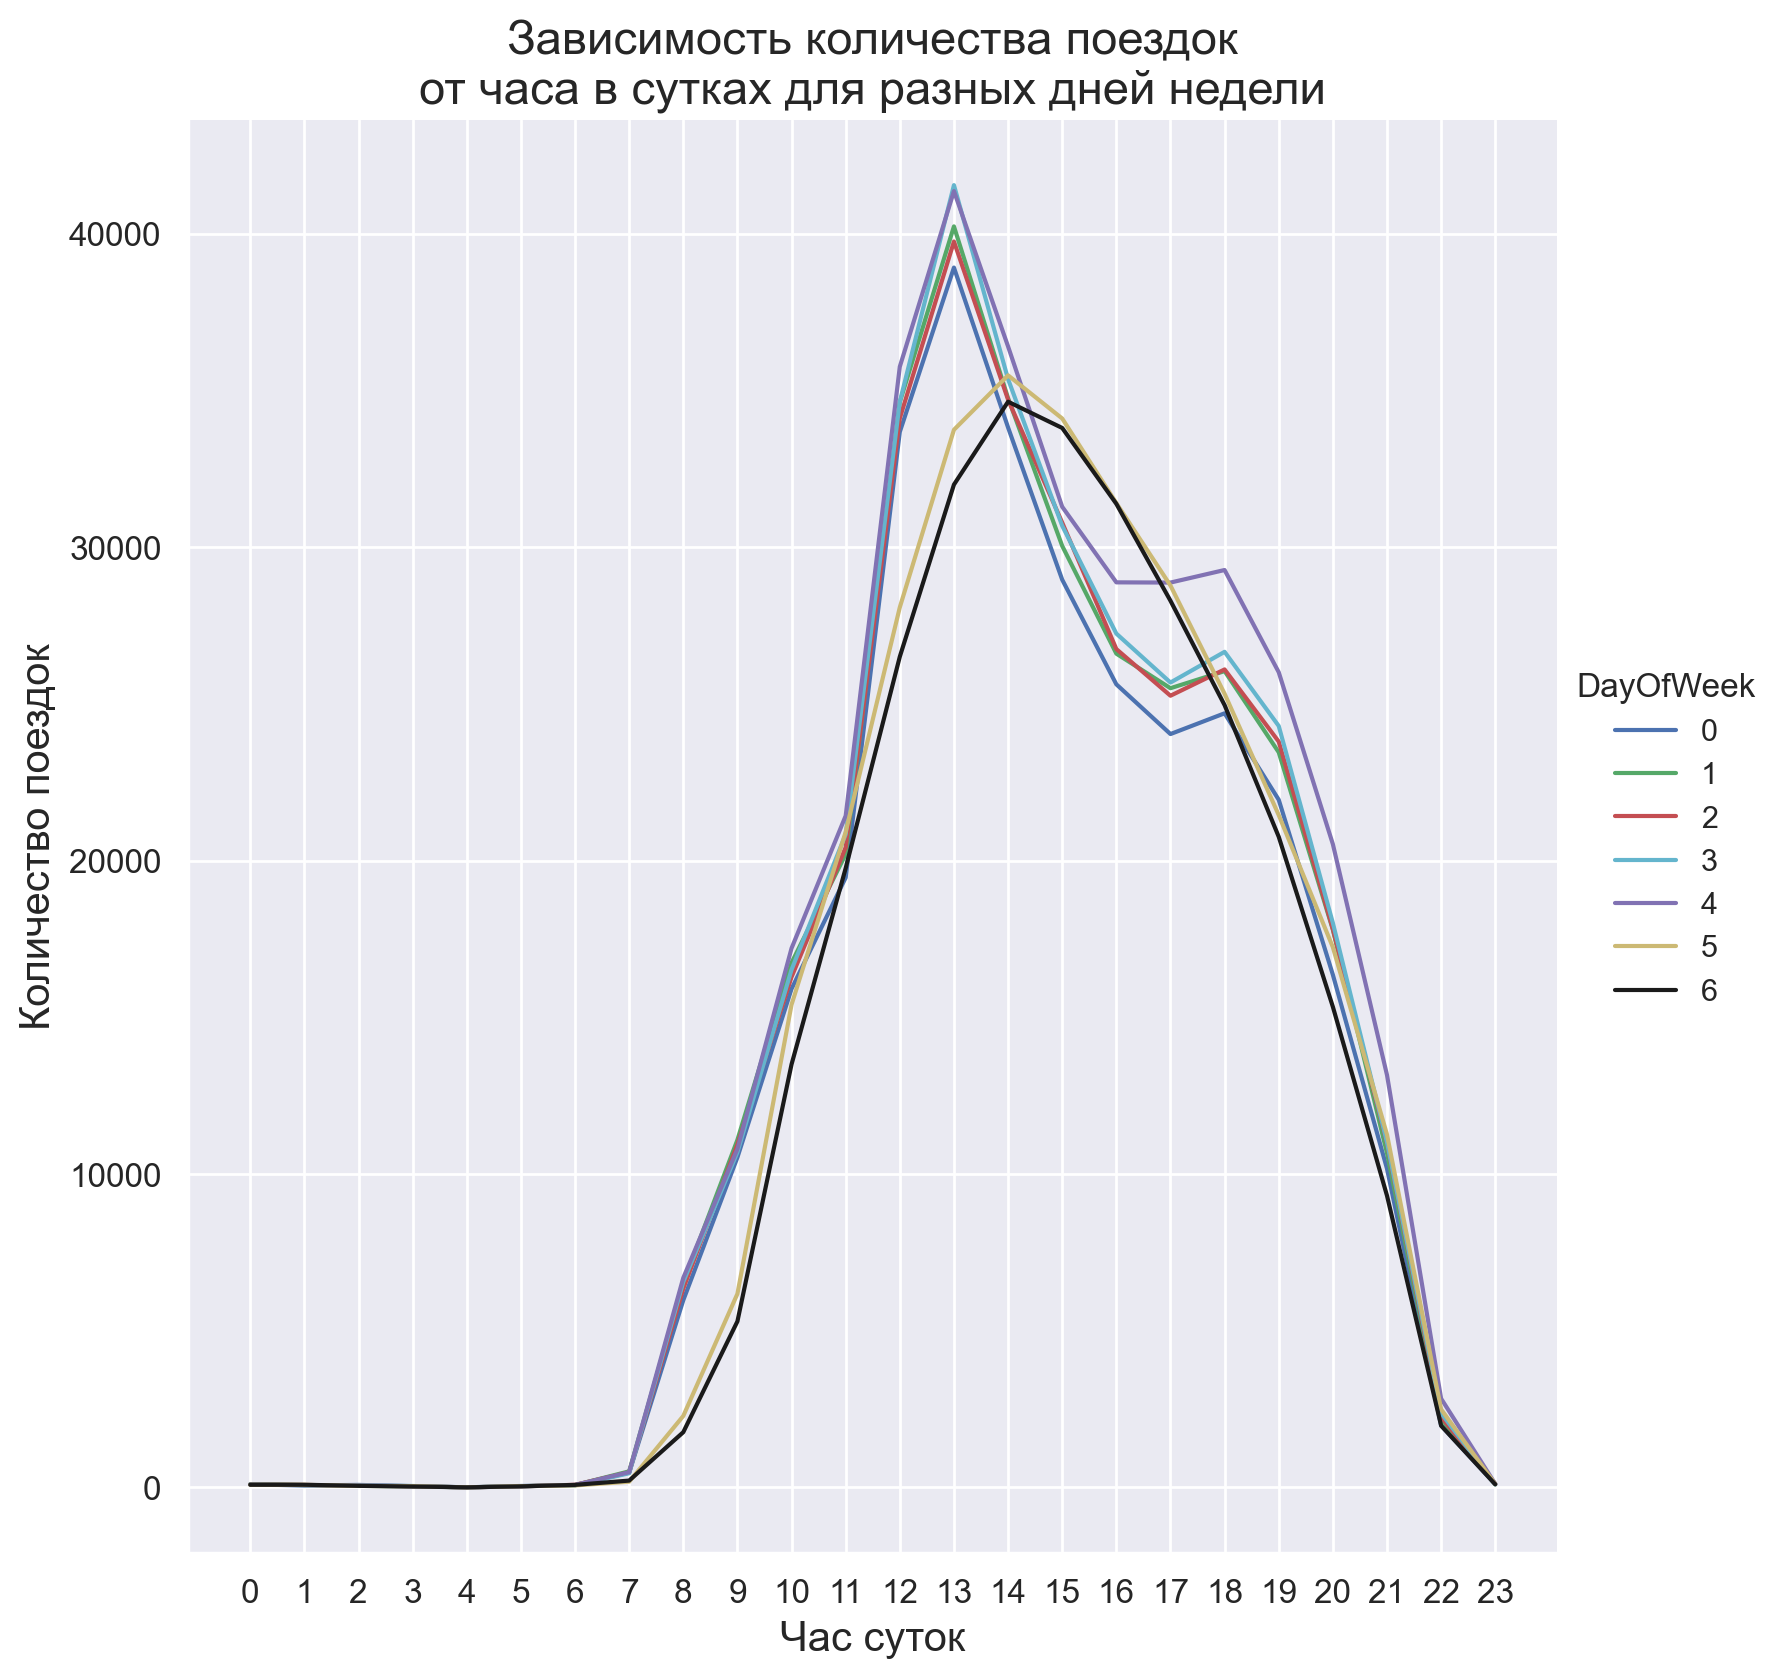

In [21]:
sns.relplot(df.groupby(['Hour', 'DayOfWeek']).UID.count().to_frame(), 
                              x = 'Hour', 
                              y = 'UID', 
                              kind='line',
                              palette=['b', 'g', 'r', 'c', 'm', 'y', 'k'],
                              height = 8, 
                              hue='DayOfWeek')
plt.title('Зависимость количества поездок\nот часа в сутках для разных дней недели', fontsize=17)
plt.xlabel('Час суток', fontsize=15)
plt.ylabel('Количество поездок', fontsize=15)
plt.xticks(np.arange(24), fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [22]:
# sns.relplot(data=df[(df['Price'] > 10) & (df['Price'] < 3000)], x="Price", y="SpentCoins", hue="DayOfWeek", height=10)
# plt.show()

## Формирование датасета с клиентами

Начинаем собирать данные по клиентам. Начинаем с последнего статуса, далее оценим покупательскую активность по RFM-анализу

In [23]:
clients = df.groupby('UID').Status.last().to_frame()

### Recency

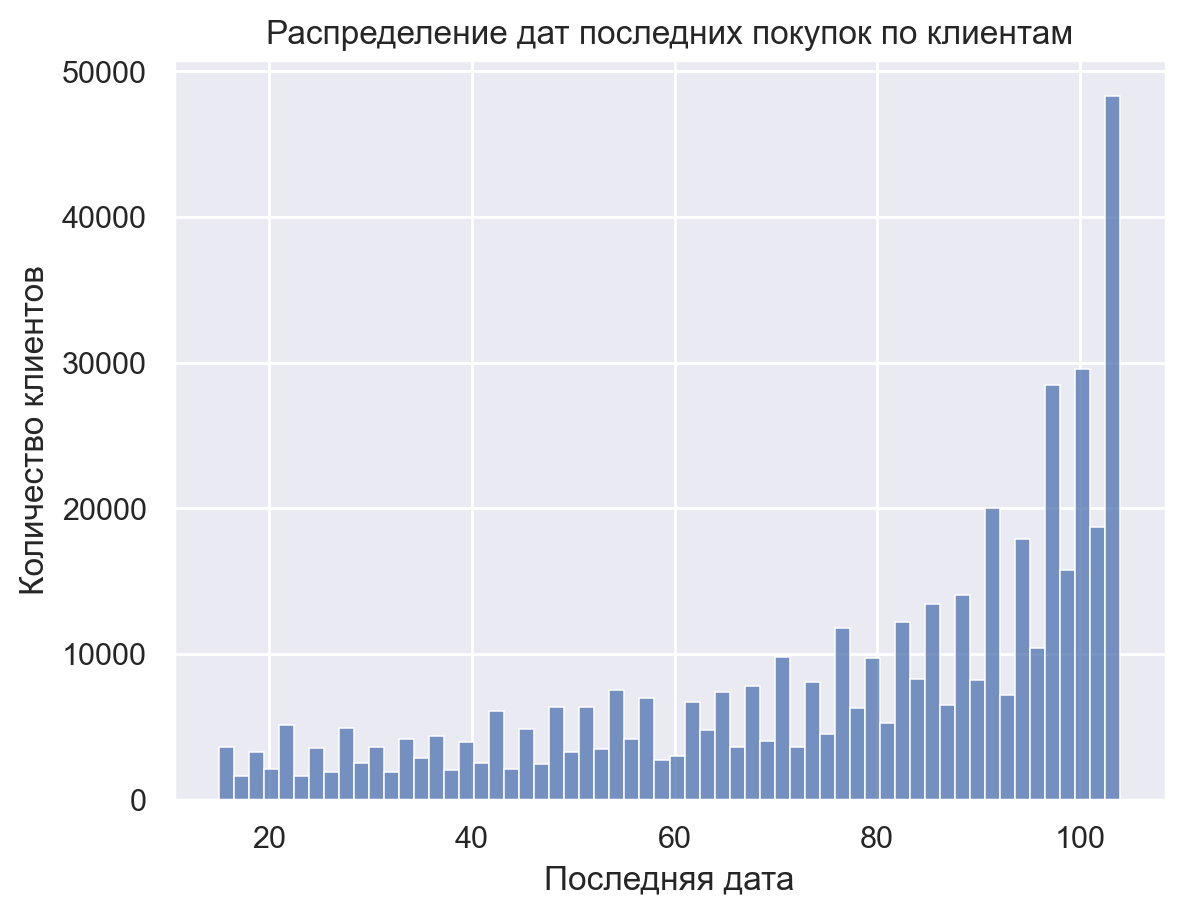

In [24]:
sns.histplot(df.groupby('UID').DayOfYear.max(), bins=60)
plt.title('Распределение дат последних покупок по клиентам')
plt.xlabel('Последняя дата')
plt.ylabel('Количество клиентов')
plt.show()

Пока в качестве Recency берём последний день в году, когда совершалась покупка. Чем больше recency, тем клиент лучше

In [25]:
clients['Recency'] = df.groupby('UID').DayOfYear.max()

## Frequency 
(рассматривать разные периоды)

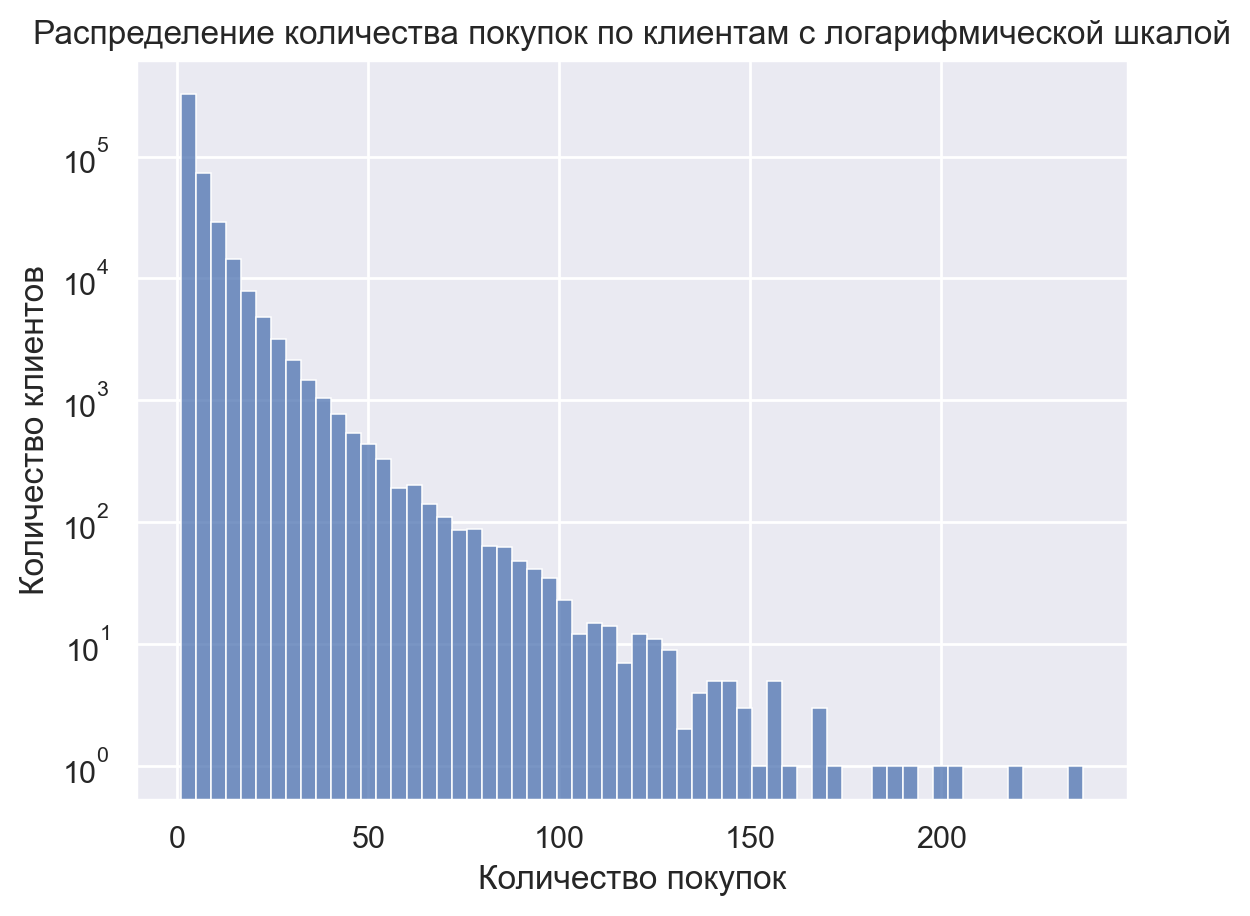

In [26]:
sns.histplot(df.groupby('UID').Price.count(), bins=60)
plt.title('Распределение количества покупок по клиентам с логарифмической шкалой')
plt.xlabel('Количество покупок')
plt.ylabel('Количество клиентов')
plt.yscale('log')
plt.show()

In [27]:
clients['Frequency'] = df.groupby('UID').Price.count()

Любимый день недели по средним тратам

In [28]:
clients['FavouriteDay'] = df.groupby(['UID', 'DayOfWeek']).Price.mean().to_frame().reset_index().sort_values(by = ['UID', 'Price'], ascending=False).groupby('UID').DayOfWeek.first()

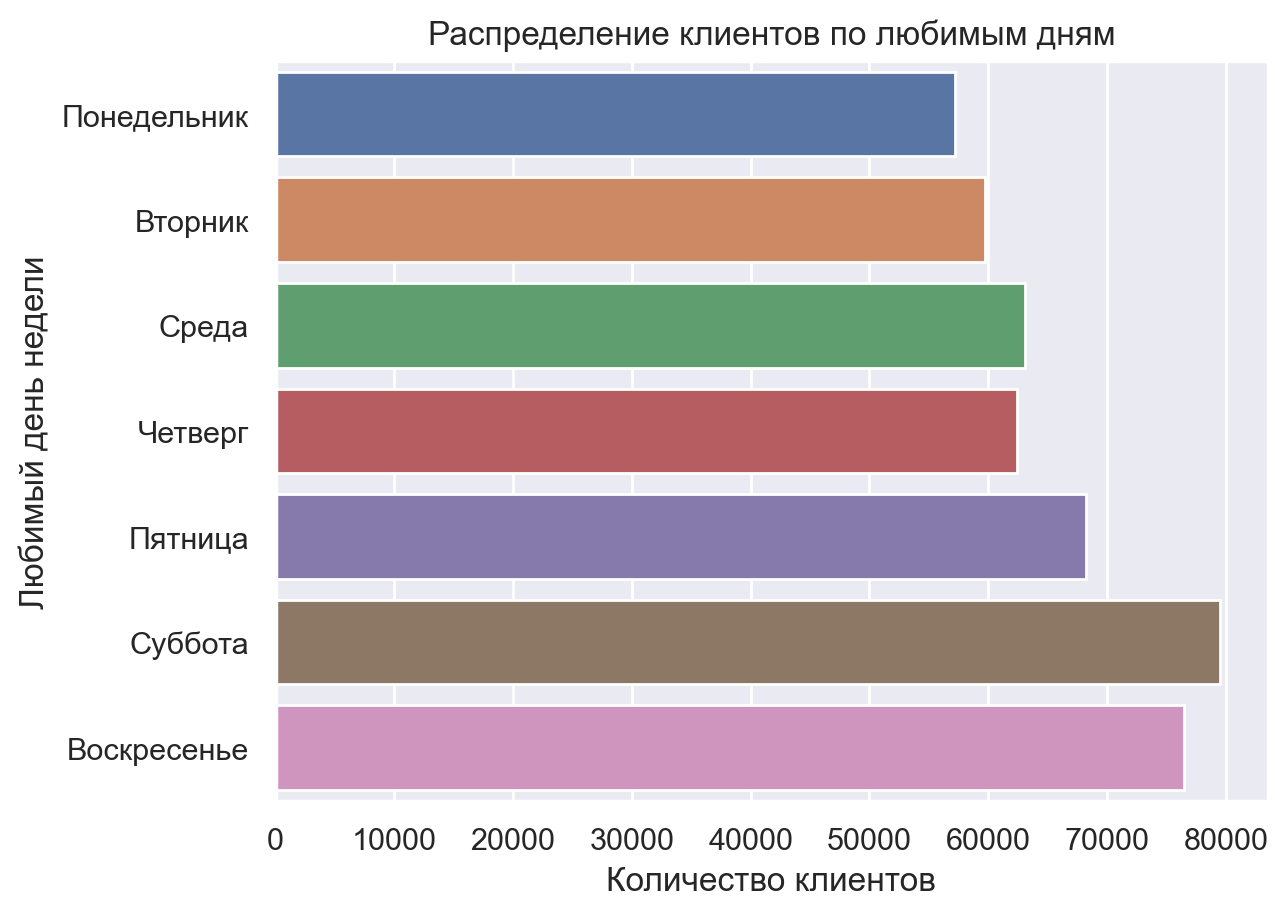

In [29]:
sns.countplot(order=range(7), y='FavouriteDay', data=clients)
plt.title('Распределение клиентов по любимым дням')
plt.xlabel("Количество клиентов")
plt.ylabel("Любимый день недели")
plt.yticks(range(7), labels=day_of_week_labels)
plt.show()

## Monetary

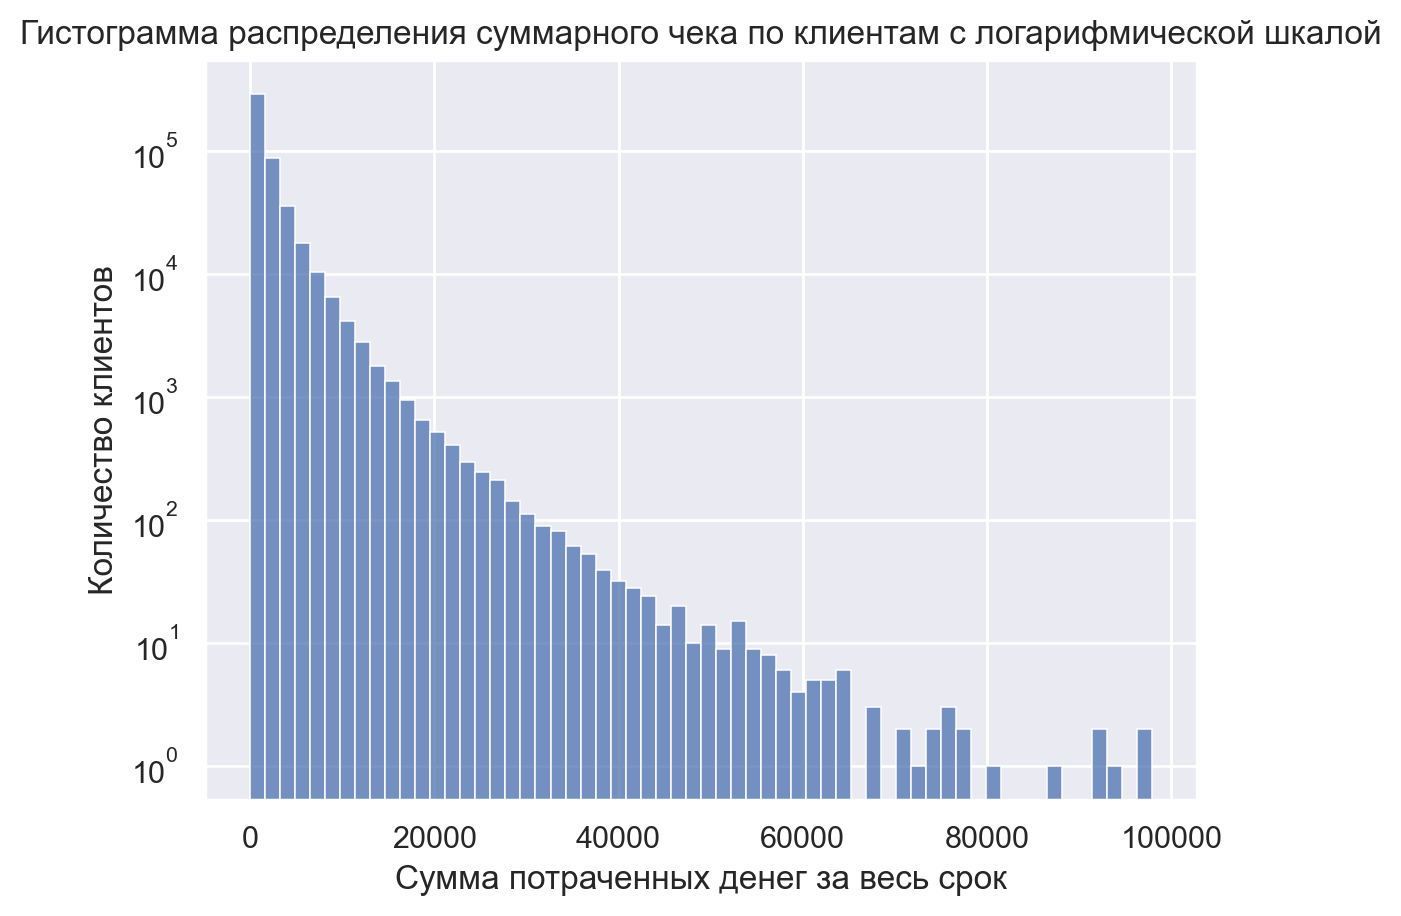

In [30]:
sns.histplot(df.groupby('UID').Price.sum(), bins=60)
plt.title('Гистограмма распределения суммарного чека по клиентам с логарифмической шкалой')
plt.xlabel('Сумма потраченных денег за весь срок')
plt.ylabel('Количество клиентов')
plt.yscale('log')
plt.show()

Для monetary попробуем две метрики - средний чек и сумма всех покупок

In [31]:
clients['Monetary_Sum'] = df.groupby('UID').Price.sum()
clients['Monetary_Mean'] = df.groupby('UID').Price.mean()

### Дополнительные признаки

Хотели добавить еще признаков типа любимый ресторан

## Формирование воздействий на клиентов и целевой переменной

### Воздействие $T_1$ - Переход на новый статус лояльности

В последствии в нашем датасете клиентов мы будем называть его TreatmentStatus

In [32]:
hierarchy = {"Бронзовый ключ": 0, "Серебряный ключ": 1, "Золотой ключ": 2, "Платиновый ключ": 3, "Сотрудник": 4}
df['StatusNew'] = df["Status"].apply(lambda x: hierarchy[x])

In [33]:
middle_data = df.loc['2023-02-15':'2023-03-15'].groupby('UID').StatusNew
clients['TreatmentStatus'] = (middle_data.is_monotonic_increasing) & (middle_data.nunique() > 1)

In [34]:
clients['TreatmentStatus'].fillna(value = False, inplace = True)
clients['TreatmentStatus'] = clients['TreatmentStatus'].astype(int)
clients

,Status,Recency,Frequency,FavouriteDay,Monetary_Sum,Monetary_Mean,TreatmentStatus
UID,,,,,,,
00004b3d-550c-11ec-80da-00155dd23e20,Бронзовый ключ,98,2,5,715.00,357.500000,0
0000582d-3d6f-11ed-80df-00155dd23e20,Платиновый ключ,83,13,6,6661.00,512.384615,0
000058d5-6d87-11ed-80e2-00155dd23e20,Платиновый ключ,100,5,4,3225.00,645.000000,0
00005d8b-08e4-11ed-80dd-00155dd23e20,Бронзовый ключ,50,3,4,2306.00,768.666667,0
0000bc9f-3799-11ea-80d4-f403433ddaaf,Серебряный ключ,101,4,1,1745.00,436.250000,0
...,...,...,...,...,...,...,...
ffff9419-16cf-11ec-80d8-00155dd23e20,Серебряный ключ,41,1,4,1601.00,1601.000000,0
ffffa515-53b1-11ed-80e0-00155dd23e20,Бронзовый ключ,53,4,2,763.00,190.750000,0
ffffac76-619a-11ed-80e1-00155dd23e20,Серебряный ключ,26,4,6,2803.00,700.750000,0


In [35]:
clients[clients['TreatmentStatus'] == 1]

,Status,Recency,Frequency,FavouriteDay,Monetary_Sum,Monetary_Mean,TreatmentStatus
UID,,,,,,,
00036ffe-ec35-11ea-80e4-f403435823a3,Серебряный ключ,104,10,3,2586.00,258.600000,1
0004200b-26ff-11ea-80d4-f403435823a3,Платиновый ключ,70,9,5,10286.00,1142.888889,1
000a3dc1-58a8-11ea-80da-f403435823a3,Золотой ключ,104,32,0,8077.00,252.406250,1
00161efe-a812-11ed-80e3-00155dd23e20,Платиновый ключ,104,45,6,17446.58,387.701778,1
0019e1b8-f6e0-11ec-80dd-00155dd23e20,Золотой ключ,71,7,5,3971.00,567.285714,1
...,...,...,...,...,...,...,...
ffe0b6e5-a77c-11ec-80db-00155dd23e20,Платиновый ключ,77,12,6,7384.14,615.345000,1
fff44a6b-994f-11ed-80e3-00155dd23e20,Золотой ключ,91,13,2,6253.00,481.000000,1
fff6d77a-adbe-11eb-80eb-f403435823a3,Платиновый ключ,94,19,0,9733.00,512.263158,1


Проверяю, что это вообще работает

In [36]:

df[df['UID'] == '0019e1b8-f6e0-11ec-80dd-00155dd23e20']

,UID,OperationType,Price,SpentCoins,GainedCoins,Point,Agent,Status,Discount,DayOfWeek,Month,Hour,DayOfYear,StatusNew
Date,,,,,,,,,,,,,,
2023-01-28 17:37:40,0019e1b8-f6e0-11ec-80dd-00155dd23e20,Покупка,691.0,0.0,13.82,Р Город Лефортово,Касса,Бронзовый ключ,0.02,5,1,17,28,0
2023-01-29 13:31:35,0019e1b8-f6e0-11ec-80dd-00155dd23e20,Покупка,889.0,0.0,26.67,Р Павелецкая Плаза,Касса,Серебряный ключ,0.03,6,1,13,29,1
2023-02-14 15:00:32,0019e1b8-f6e0-11ec-80dd-00155dd23e20,Покупка,453.0,0.0,13.59,Р Никольская,Касса,Серебряный ключ,0.03,1,2,15,45,1
2023-02-14 15:01:54,0019e1b8-f6e0-11ec-80dd-00155dd23e20,Покупка,325.0,0.0,9.75,Р Никольская,Касса,Серебряный ключ,0.03,1,2,15,45,1
2023-02-14 15:04:08,0019e1b8-f6e0-11ec-80dd-00155dd23e20,Покупка,1.0,214.0,0.03,Р Никольская,Касса,Серебряный ключ,0.03,1,2,15,45,1
2023-03-11 18:02:40,0019e1b8-f6e0-11ec-80dd-00155dd23e20,Покупка,1385.0,0.0,41.55,Р Авиа Парк,Касса,Серебряный ключ,0.03,5,3,18,70,1
2023-03-12 15:24:52,0019e1b8-f6e0-11ec-80dd-00155dd23e20,Покупка,227.0,0.0,11.35,Р Город Лефортово,Касса,Золотой ключ,0.05,6,3,15,71,2


### Воздействие $T_2$ - Использование баллов Спасибо

**Рассуждения**

$round((price - sber) * discount, 2) = gained\_coins$

По правилам округления до сотых делаем оценку

$(price - sber) * discount = gained\_coins \pm 0.005$

$price - sber = \frac{gained\_coins \pm 0.005}{discount}$

$sber = price - \frac{gained\_coins \pm 0.005}{discount}$

$sber = price - \frac{gained\_coins}{discount} \pm \frac{0.005}{discount}$

Оцениваем $\frac{0.005}{discount}$ по максимально возможному значению скидки $0.02: \frac{0.005}{0.02} = 0.25$

Значит, во всех транзакциях, где полученный $sber$ больше 0.25 мы имели дело с реальным использованием баллов Спасибо

**Вывод**

Для надёжности и логичности введём порог на воздействие с помощью баллов Спасибо в размере 10 рублей

In [37]:
df['SberSpasibo'] = 0
df.loc[df.Price - df.GainedCoins / df.Discount > 10, 'SberSpasibo'] = 1
clients['SberSpasibo'] = df.groupby('UID').SberSpasibo.any()

In [38]:
df[(df['SberSpasibo'] > 0) & (df['Agent'] != 'Касса') & (df['OperationType'] != 'Возврат')]

,UID,OperationType,Price,SpentCoins,GainedCoins,Point,Agent,Status,Discount,DayOfWeek,Month,Hour,DayOfYear,StatusNew,SberSpasibo
Date,,,,,,,,,,,,,,,
2023-01-15 11:13:29,e7617eb3-ee56-11ec-80dd-00155dd23e20,Покупка,687.0,0.0,0.00,Р Форт Отрадное,Мобильное приложение,Бронзовый ключ,0.02,6,1,11,15,0,1
2023-01-15 11:17:21,0957330a-64c9-11ed-80e1-00155dd23e20,Покупка,690.0,0.0,7.88,Р Ашан Гагаринский,Мобильное приложение,Бронзовый ключ,0.02,6,1,11,15,0,1
2023-01-15 11:47:32,4e3b02fa-2ef0-11ea-80d4-f403435823a3,Покупка,671.0,0.0,22.40,Р Колумбус Южная Галерея,Мобильное приложение,Платиновый ключ,0.07,6,1,11,15,3,1
2023-01-15 12:11:06,80369a97-94b2-11ed-80e3-00155dd23e20,Покупка,86.0,0.0,0.00,Р XL Мытищи,Мобильное приложение,Бронзовый ключ,0.02,6,1,12,15,0,1
2023-01-15 12:23:17,ee218de3-4d0d-11eb-80e6-f403435823a3,Покупка,764.0,0.0,24.20,Р Новогиреево,Мобильное приложение,Золотой ключ,0.05,6,1,12,15,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-14 20:39:37,f876c82a-27fe-11eb-80e5-f403435823a3,Покупка,240.0,0.0,0.00,Р Конфитюр Железнодорожный,Мобильное приложение,Золотой ключ,0.05,4,4,20,104,2,1
2023-04-14 20:40:27,9e4bf418-98d7-11ed-80e3-00155dd23e20,Покупка,806.0,0.0,5.80,Р Фестиваль СТР,Мобильное приложение,Бронзовый ключ,0.02,4,4,20,104,0,1
2023-04-14 20:51:27,9b30e7e7-933c-11ed-80e3-00155dd23e20,Покупка,322.0,0.0,0.00,Р Колумбус Южная Галерея,Мобильное приложение,Серебряный ключ,0.03,4,4,20,104,1,1


## Целевая переменная $Y$ (непрерывная)

In [39]:
clients['first_part'] = df.loc[:'2023-03-01'].groupby('UID').Price.sum()
clients['first_part'].fillna(0, inplace=True)
clients['second_part'] = df.groupby('UID').Price.sum() - clients['first_part']
clients['conversion'] = clients['second_part'] - clients['first_part']

## Целевая переменная $Y$ (бинарная)

Это пока что заглушка для проверки

In [40]:
clients['binary_outcome_1'] = (clients['conversion'] > 100).astype(int)

## Целевая переменная Y(Эксперимент с causes and outcomes)

### Запускать только в случае если это нужно

In [41]:
clients['Recency'] = df.loc['2023-02-15':].groupby('UID').DayOfYear.max()
clients['Frequency'] = df.loc['2023-02-15':].groupby('UID').Price.count()
clients['Monetary_Sum'] = df.loc['2023-02-15':].groupby('UID').Price.sum()
clients['Monetary_Mean'] = df.loc['2023-02-15':].groupby('UID').Price.mean()


In [42]:
clients['outcome'] = df.loc['2023-03-15':].groupby('UID').Price.sum()
clients['outcome'].fillna(0, inplace=True)
clients.dropna(inplace=True)
print(clients.shape)

(400717, 13)


## CausalML

Установка пакета

In [ ]:
!pip install causalml

Импортирую функции

In [43]:
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
import shap 

import causalml
from causalml.metrics import plot_gain, plot_qini, qini_score
from causalml.dataset import synthetic_data
from causalml.inference.tree import plot_dist_tree_leaves_values, get_tree_leaves_mask
from causalml.inference.tree import CausalRandomForestRegressor, CausalTreeRegressor
from causalml.inference.tree.utils import timeit

/Users/georgij/anaconda3/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Failed to import duecredit due to No module named 'duecredit'


### Causal Trees

In [46]:
df_train, df_test = train_test_split(clients, test_size=0.2, random_state=111)
n_train, n_test = df_train.shape[0], df_test.shape[0]

#feature_names = ['Status', 'Recency', 'Frequency', 'Monetary_Sum', 'Monetary_Mean']
#Сделать из Status is_bronze, is_gold и тп, чтобы было OHE, но с именами, чтобы посмотреть потом важность признаков
feature_names = ['Recency', 'Frequency', 'Monetary_Sum', 'Monetary_Mean'] # здесь будет больше признаков когда мы придумаем как их переделать в числовые

X_train, y_train = df_train[feature_names], df_train['conversion'].values
X_test, y_test = df_test[feature_names], df_test['conversion'].values
treatment_train, treatment_test = df_train['TreatmentStatus'].values, df_test['TreatmentStatus'].values
#effect_test = df_test['treatment_effect'].values я пока не понял зачем это

#observation = X_test.loc[[0]] я пока не понял зачем это

In [ ]:
ctree = CausalTreeRegressor()
ctree.fit(X=X_train.values, y=y_train, treatment=treatment_train)

In [ ]:
cate_tree_test = ctree.predict(X_test.values) #отдает TE - treatment effect
cate_tree_train = ctree.predict(X_train.values)

In [ ]:
df_importances = pd.DataFrame({'tree': ctree.feature_importances_, 
                               'feature': feature_names
                              })
#forest_std = np.std([tree.feature_importances_ for tree in crforest.estimators_], axis=0)

fig, ax = plt.subplots()
df_importances['tree'].plot.bar(ax=ax)
ax.set_title("Causal Tree feature importances")
ax.set_ylabel("Mean decrease in impurity")
ax.set_xticklabels(feature_names, rotation=45)
plt.show()


### Regressors

In [ ]:
from causalml.inference.meta import LRSRegressor
from causalml.inference.meta import XGBTRegressor, MLPTRegressor
from causalml.inference.meta import BaseXRegressor
from causalml.inference.meta import BaseRRegressor
from xgboost import XGBRegressor
#from causalml.dataset import synthetic_data

#y, X, treatment, _, _, e = synthetic_data(mode=1, n=1000, p=5, sigma=1.0)

X, y, treatment = clients[feature_names], clients['conversion'], clients['TreatmentStatus']

lr = LRSRegressor()
te, lb, ub = lr.estimate_ate(X, treatment, y)
print('Average Treatment Effect (Linear Regression): {:.2f} ({:.2f}, {:.2f})'.format(te[0], lb[0], ub[0]))

xg = XGBTRegressor(random_state=42)
te, lb, ub = xg.estimate_ate(X, treatment, y)
print('Average Treatment Effect (XGBoost): {:.2f} ({:.2f}, {:.2f})'.format(te[0], lb[0], ub[0]))

nn = MLPTRegressor(hidden_layer_sizes=(10, 10),
                 learning_rate_init=.1,
                 early_stopping=True,
                 random_state=42)
te, lb, ub = nn.estimate_ate(X, treatment, y)
print('Average Treatment Effect (Neural Network (MLP)): {:.2f} ({:.2f}, {:.2f})'.format(te[0], lb[0], ub[0]))

#xl = BaseXRegressor(learner=XGBRegressor(random_state=42))
#te, lb, ub = xl.estimate_ate(X, treatment, y, e)
#print('Average Treatment Effect (BaseXRegressor using XGBoost): {:.2f} ({:.2f}, {:.2f})'.format(te[0], lb[0], ub[0]))

#rl = BaseRRegressor(learner=XGBRegressor(random_state=42))
#te, lb, ub =  rl.estimate_ate(X=X, p=e, treatment=treatment, y=y)
#print('Average Treatment Effect (BaseRRegressor using XGBoost): {:.2f} ({:.2f}, {:.2f})'.format(te[0], lb[0], ub[0]))

## Meta-Learners

In [ ]:
from causalml.inference.meta import LRSRegressor
from causalml.inference.meta import XGBTRegressor, MLPTRegressor
from causalml.inference.meta import BaseXRegressor, BaseRRegressor, BaseSRegressor, BaseTRegressor

# S Learner
learner_s = LRSRegressor()
cate_s = learner_s.fit_predict(X=X, treatment=treatment, y=y, verbose=True)

print('S Learner is fitted')

# T Learner
learner_t = BaseTRegressor(learner=XGBRegressor())
cate_t = learner_t.fit_predict(X=X, treatment=treatment, y=y, verbose=True)

print('T Learner is fitted')

# X Learner with propensity score input
#learner_x = BaseXRegressor(learner=XGBRegressor())
#cate_x = learner_x.fit_predict(X=X, treatment=treatment, y=y, p=e)

# X Learner without propensity score input
learner_x_no_p = BaseXRegressor(learner=XGBRegressor())
cate_x_no_p = learner_x_no_p.fit_predict(X=X, treatment=treatment, y=y, verbose=True)

print('X Learner is fitted')

# R Learner with propensity score input 
#learner_r = BaseRRegressor(learner=XGBRegressor())
#cate_r = learner_r.fit_predict(X=X, treatment=treatment, y=y, p=e)

# R Learner without propensity score input
learner_r_no_p = BaseRRegressor(learner=XGBRegressor())
cate_r_no_p = learner_r_no_p.fit_predict(X=X, treatment=treatment, y=y, verbose=True)

print('R Learner is fitted')

In [ ]:
cate_tree = ctree.predict(X) #отдает TE - treatment effect

In [ ]:
alpha=0.2
bins=30
plt.figure(figsize=(12,8))

plt.hist(cate_tree, alpha=alpha, bins=bins, label='CausalTree')

plt.hist(cate_t, alpha=alpha, bins=bins, label='T Learner')
#plt.hist(cate_x, alpha=alpha, bins=bins, label='X Learner')
plt.hist(cate_x_no_p, alpha=alpha, bins=bins, label='X Learner (no propensity score)')
#plt.hist(cate_r, alpha=alpha, bins=bins, label='R Learner')
plt.hist(cate_r_no_p, alpha=alpha, bins=bins, label='R Learner (no propensity score)')
plt.vlines(cate_s[0], 0, 1e6, label='S Learner', linestyles='dotted', colors='green', linewidth=2)
plt.title('Distribution of CATE Predictions by Meta Learner')
plt.xlabel('Individual Treatment Effect (ITE/CATE)')
plt.ylabel('# of Samples')
plt.yscale('log')
plt.legend()
plt.show()

In [ ]:
df_preds_train = pd.DataFrame([cate_tree.ravel(),
                               cate_s.ravel(),
                               cate_t.ravel(),
                               cate_x_no_p.ravel(),
                               cate_r_no_p.ravel(),
                               treatment.ravel(),
                               y.ravel()],
                               index=['Tree','S','T','X','R','w','y']).T

#df_cumgain_train = get_cumgain(df_preds_train)

In [ ]:
from causalml.metrics import *
plot_gain(df_preds_train)

In [ ]:
clients[cate_x_no_p > 0]['TreatmentStatus'].mean()

В теории можем их всех затаргетить и все

А можем по трем самым сильным моделям посмотреть и затаргетить только их

In [ ]:
clients[(cate_x_no_p > 0) & (cate_r_no_p > 0) & (cate_t > 0)].shape

### UpliftTreeClassifier (для бинарного Y)

In [ ]:
clients_for_uplift = clients.copy(deep=True) #делается из-за того, что здесь нужно помечать группы иначе

In [ ]:
clients_for_uplift['TreatmentStatus'].replace({0: 'control', 1: 'treatment1'}, inplace=True)

In [ ]:
df_train, df_test = train_test_split(clients_for_uplift, test_size=0.2, random_state=111)
n_train, n_test = df_train.shape[0], df_test.shape[0]

#feature_names = ['Status', 'Recency', 'Frequency', 'Monetary_Sum', 'Monetary_Mean']
#Сделать из Status is_bronze, is_gold и тп, чтобы было OHE, но с именами, чтобы посмотреть потом важность признаков
feature_names = ['Recency', 'Frequency', 'Monetary_Sum', 'Monetary_Mean'] # здесь будет больше признаков когда мы придумаем как их переделать в числовые

X_train, y_train = df_train[feature_names], df_train['binary_outcome_1'].values
X_test, y_test = df_test[feature_names], df_test['binary_outcome_1'].values
treatment_train, treatment_test = df_train['TreatmentStatus'].values, df_test['TreatmentStatus'].values

In [ ]:
from causalml.dataset import make_uplift_classification
lol, x_names = make_uplift_classification()

In [ ]:
from IPython.display import Image
from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
from causalml.inference.tree import uplift_tree_string, uplift_tree_plot

uplift_model = UpliftTreeClassifier(max_depth=5, min_samples_leaf=200, min_samples_treatment=50,
                                    n_reg=100, evaluationFunction='KL', control_name='control')

uplift_model.fit(X_train.values,
                 treatment=treatment_train,
                 y=y_train)

graph = uplift_tree_plot(uplift_model.fitted_uplift_tree, feature_names)
Image(graph.create_png())

## Эксперименты с Causes/Outcome

### Запускать только в случае эксперимента

In [44]:
from causalml.inference.meta import BaseXRegressor, BaseRRegressor, BaseSRegressor, BaseTRegressor

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor

from causalml.metrics import *

feature_names = ['Recency', 'Frequency', 'Monetary_Sum', 'Monetary_Mean'] 
X, y, treatment = clients[feature_names + ['FavouriteDay', 'SberSpasibo']], clients['outcome'], clients['TreatmentStatus']

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown='ignore'), ['FavouriteDay', 'SberSpasibo']),
    ('scaling', StandardScaler(),feature_names),
])

X = column_transformer.fit_transform(X)


### MetaLearners XGBoost

In [47]:
from tqdm import tqdm
best_params = {}

In [52]:
# S Learner with XGBoost searching hyperparameters

best_params['S_XGBoost'] = {'n_estimators': 0, 'max_depth': 0, 'lr': 0}
best_qini = 0
with tqdm(total=27) as pbar:
    for n_estimators in [200, 400, 600]:
        for max_depth in [20, 40, 60]:
            for lr in [1e-3, 1e-2, 1e-1]:
                learner_s_xgboost = BaseSRegressor(learner=XGBRegressor(n_estimators = n_estimators, 
                                                                        max_depth = max_depth, 
                                                                        learning_rate = lr, gpu_id=1))
                cate_s_xgboost = learner_s_xgboost.fit_predict(X=X, treatment=treatment, y=y, verbose=True)
                df_preds_xgboost = pd.DataFrame([
                                   cate_s_xgboost.ravel(),
                                   treatment.ravel(),
                                   y.ravel()],
                                   index=['S Xgboost','w','y']).T
                cur_qini = get_qini(df_preds_xgboost).sum(axis=0)['S Xgboost']
                if cur_qini > best_qini:
                    best_params['S_XGBoost']['n_estimators'] = n_estimators
                    best_params['S_XGBoost']['max_depth'] = max_depth
                    best_params['S_XGBoost']['lr'] = lr
                    best_qini = cur_qini
                pbar.update(1)


                
print('Best parameters for S_XGBoost:')
print(best_params['S_XGBoost'])

100%|████████████████████████████████████████| 27/27 [1:19:09<00:00, 175.90s/it]

Best parameters for S_XGBoost:
{'n_estimators': 400, 'max_depth': 60, 'lr': 0.01}


In [53]:
# T Learner with XGBoost searching hyperparameters

best_params['T_XGBoost'] = {'n_estimators': 0, 'max_depth': 0, 'lr': 0}
best_qini = 0
with tqdm(total=27) as pbar:
    for n_estimators in [200, 400, 600]:
        for max_depth in [20, 40, 60]:
            for lr in [1e-3, 1e-2, 1e-1]:
                learner_t_xgboost = BaseTRegressor(learner=XGBRegressor(n_estimators = n_estimators, 
                                                                        max_depth = max_depth, 
                                                                        learning_rate = lr, gpu_id=1))
                cate_t_xgboost = learner_t_xgboost.fit_predict(X=X, treatment=treatment, y=y, verbose=True)
                df_preds_xgboost = pd.DataFrame([
                                   cate_t_xgboost.ravel(),
                                   treatment.ravel(),
                                   y.ravel()],
                                   index=['T Xgboost','w','y']).T
                cur_qini = get_qini(df_preds_xgboost).sum(axis=0)['T Xgboost']
                if cur_qini > best_qini:
                    best_params['T_XGBoost']['n_estimators'] = n_estimators
                    best_params['T_XGBoost']['max_depth'] = max_depth
                    best_params['T_XGBoost']['lr'] = lr
                    best_qini = cur_qini
                pbar.update(1)

print('Best parameters for T_XGBoost:')
print(best_params['T_XGBoost'])

100%|████████████████████████████████████████| 27/27 [1:13:21<00:00, 163.01s/it]

Best parameters for T_XGBoost:
{'n_estimators': 400, 'max_depth': 40, 'lr': 0.01}


In [48]:
# X Learner with XGBoost searching hyperparameters               

best_params['X_XGBoost'] = {'n_estimators': 0, 'max_depth': 0, 'lr': 0}
best_qini = 0
with tqdm(total=27) as pbar:
    for n_estimators in [200, 400, 600]:
        for max_depth in [20, 40, 60]:
            for lr in [1e-3, 1e-2, 1e-1]:
                learner_x_xgboost = BaseXRegressor(learner=XGBRegressor(n_estimators = n_estimators, 
                                                                        max_depth = max_depth, 
                                                                        learning_rate = lr, gpu_id=1))
                cate_x_xgboost = learner_x_xgboost.fit_predict(X=X, treatment=treatment, y=y, verbose=True)
                df_preds_xgboost = pd.DataFrame([
                                   cate_x_xgboost.ravel(),
                                   treatment.ravel(),
                                   y.ravel()],
                                   index=['X Xgboost','w','y']).T
                cur_qini = get_qini(df_preds_xgboost).sum(axis=0)['X Xgboost']
                if cur_qini > best_qini:
                    best_params['X_XGBoost']['n_estimators'] = n_estimators
                    best_params['X_XGBoost']['max_depth'] = max_depth
                    best_params['X_XGBoost']['lr'] = lr
                    best_qini = cur_qini
                pbar.update(1)

print('Best parameters for X_XGBoost:')
print(best_params['X_XGBoost'])

100%|████████████████████████████████████████| 27/27 [2:59:45<00:00, 399.45s/it]

Best parameters for X_XGBoost:
{'n_estimators': 600, 'max_depth': 60, 'lr': 0.001}


In [52]:
best_params

{'X_XGBoost': {'n_estimators': 600, 'max_depth': 60, 'lr': 0.001},
 'S_XGBoost': {'n_estimators': 400, 'max_depth': 60, 'lr': 0.01},
 'T_XGBoost': {'n_estimators': 400, 'max_depth': 40, 'lr': 0.01}}

In [53]:
# S Learner with XGBoost
learner_s_xgboost = BaseSRegressor(learner=XGBRegressor(n_estimators = best_params['S_XGBoost']['n_estimators'], 
                                                        max_depth = best_params['S_XGBoost']['max_depth'], 
                                                        learning_rate = best_params['S_XGBoost']['lr']))
cate_s_xgboost = learner_s_xgboost.fit_predict(X=X, treatment=treatment, y=y, verbose=True)

print('S Learner on XGBoost is fitted')

# T Learner with XGBoost
learner_t_xgboost = BaseTRegressor(learner=XGBRegressor(n_estimators = best_params['T_XGBoost']['n_estimators'], 
                                                        max_depth = best_params['T_XGBoost']['max_depth'], 
                                                        learning_rate = best_params['T_XGBoost']['lr']))
cate_t_xgboost = learner_t_xgboost.fit_predict(X=X, treatment=treatment, y=y, verbose=True)

print('T Learner on XGBoost is fitted')

# X Learner with XGBoost
learner_x_xgboost = BaseXRegressor(learner=XGBRegressor(n_estimators = best_params['X_XGBoost']['n_estimators'], 
                                                        max_depth = best_params['X_XGBoost']['max_depth'], 
                                                        learning_rate = best_params['X_XGBoost']['lr']))
cate_x_xgboost = learner_x_xgboost.fit_predict(X=X, treatment=treatment, y=y, verbose=True)

print('X Learner on XGBoost is fitted')


S Learner on XGBoost is fitted
T Learner on XGBoost is fitted
X Learner on XGBoost is fitted


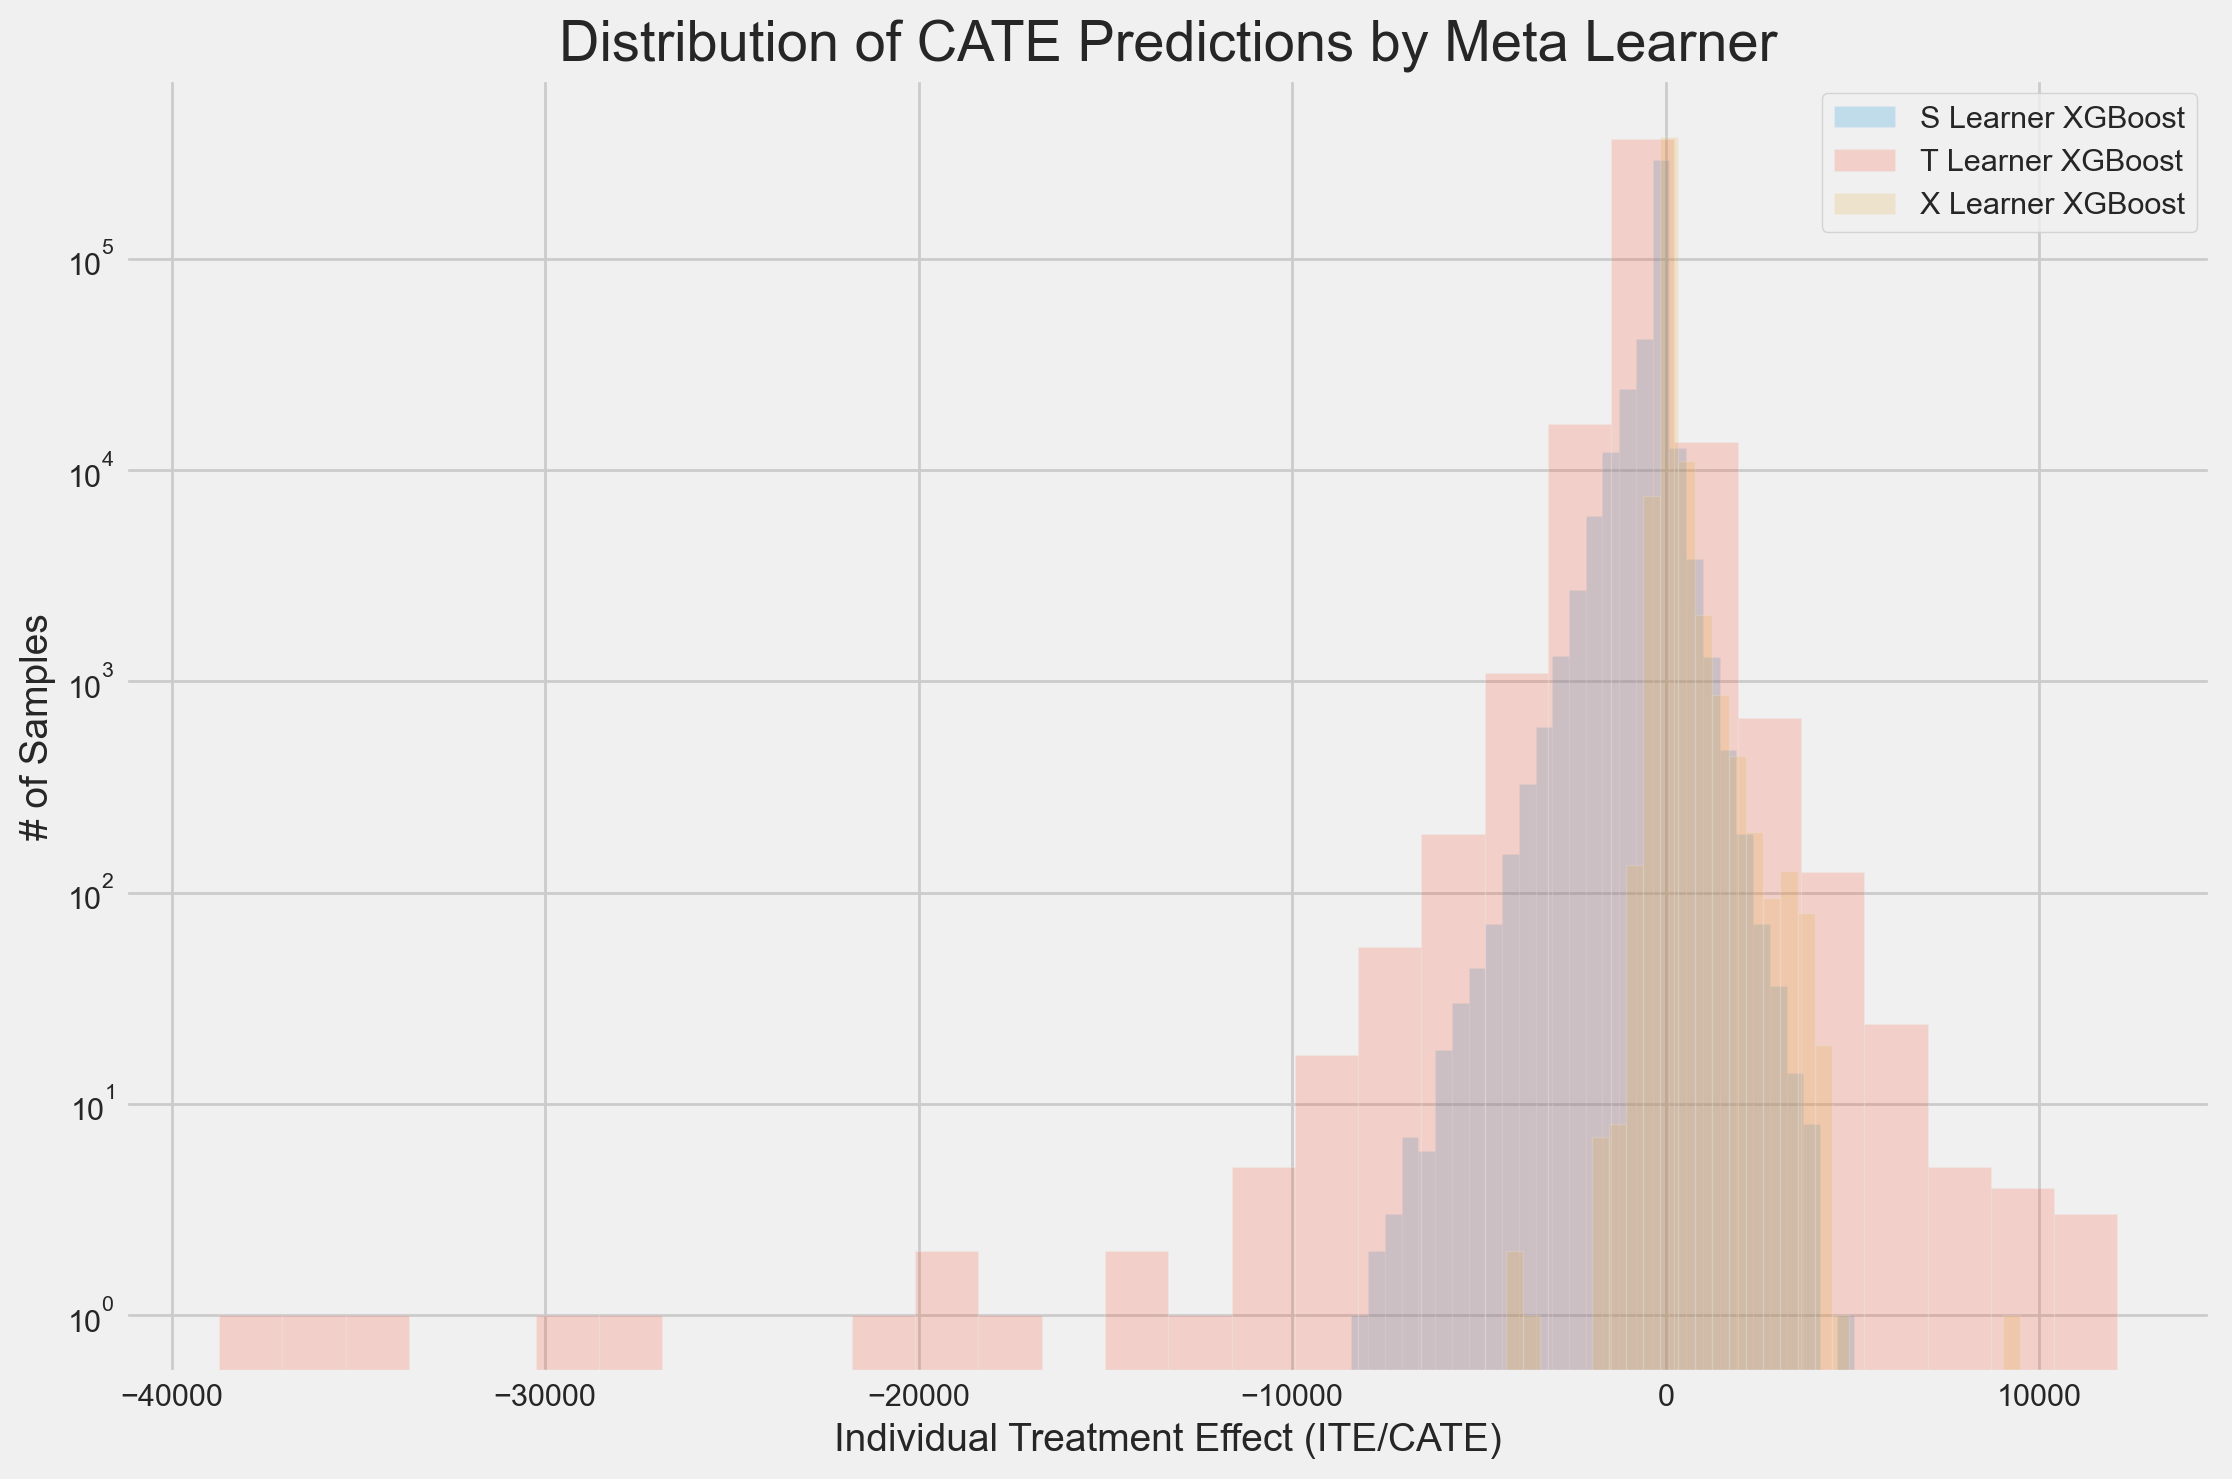

In [58]:
alpha=0.2
bins=30
plt.figure(figsize=(12,8))

plt.hist(cate_s_xgboost, alpha=alpha, bins=bins, label='S Learner XGBoost')
plt.hist(cate_t_xgboost, alpha=alpha, bins=bins, label='T Learner XGBoost')
plt.hist(cate_x_xgboost, alpha=alpha, bins=bins, label='X Learner XGBoost')


plt.title('Distribution of CATE Predictions by Meta Learner')
plt.xlabel('Individual Treatment Effect (ITE/CATE)')
plt.ylabel('# of Samples')
plt.yscale('log')
plt.legend()
plt.show()

In [59]:
df_preds_xgboost = pd.DataFrame([cate_s_xgboost.ravel(),
                               cate_t_xgboost.ravel(),
                               cate_x_xgboost.ravel(),
                               treatment.ravel(),
                               y.ravel()],
                               index=['S Xgboost','T Xgboost','X Xgboost','w','y']).T

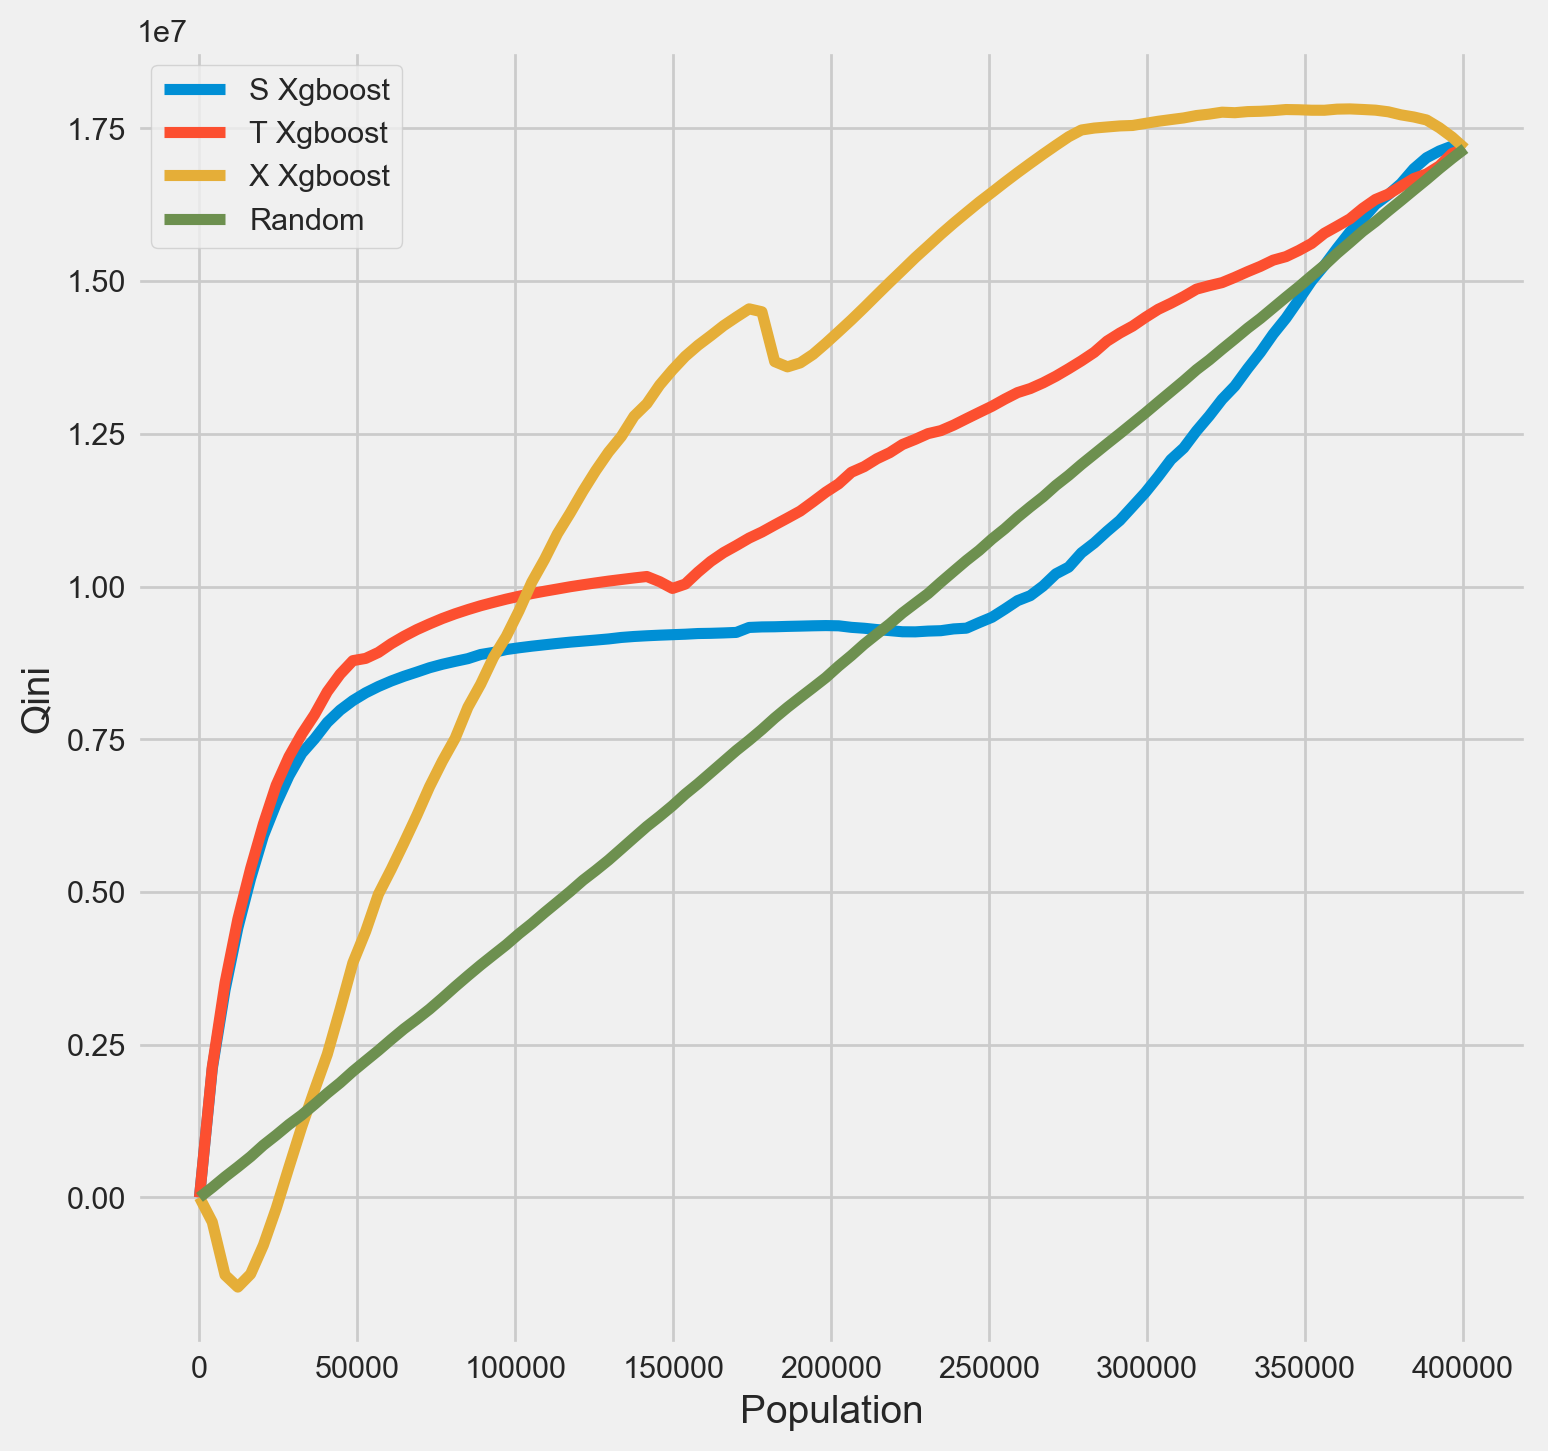

In [60]:
plot_qini(df_preds_xgboost)

### MetaLearners MLP

In [64]:
from sklearn.neural_network import MLPRegressor

# S Learner with MLP searching hyperparameters

best_params['S_MLP'] = {'hls': []}
best_qini = 0
with tqdm(total=6) as pbar:
    for hls in [[100], [100, 100], [200], [200, 200], [300], [300, 300]]:
        learner_s_mlp = BaseSRegressor(learner=MLPRegressor(hidden_layer_sizes = hls))
        cate_s_mlp = learner_s_mlp.fit_predict(X=X, treatment=treatment, y=y, verbose=True)
        df_preds_mlp = pd.DataFrame([
                           cate_s_mlp.ravel(),
                           treatment.ravel(),
                           y.ravel()],
                           index=['S MLP','w','y']).T
        cur_qini = get_qini(df_preds_mlp).sum(axis=0)['S MLP']
        if cur_qini > best_qini:
            best_params['S_MLP']['hls'] = hls
            best_qini = cur_qini
        pbar.update(1)


                
print('Best parameters for S_MLP:')
print(best_params['S_MLP'])

100%|████████████████████████████████████████████| 6/6 [36:10<00:00, 361.67s/it]

Best parameters for S_MLP:
{'hls': [100]}
Qini: 2264279891189.1616


In [65]:
from sklearn.neural_network import MLPRegressor

# S Learner with MLP searching hyperparameters

best_params['T_MLP'] = {'hls': []}
best_qini = 0
with tqdm(total=6) as pbar:
    for hls in [[100], [100, 100], [200], [200, 200], [300], [300, 300]]:
        learner_t_mlp = BaseTRegressor(learner=MLPRegressor(hidden_layer_sizes = hls))
        cate_t_mlp = learner_t_mlp.fit_predict(X=X, treatment=treatment, y=y, verbose=True)
        df_preds_mlp = pd.DataFrame([
                           cate_t_mlp.ravel(),
                           treatment.ravel(),
                           y.ravel()],
                           index=['T MLP','w','y']).T
        cur_qini = get_qini(df_preds_mlp).sum(axis=0)['T MLP']
        if cur_qini > best_qini:
            best_params['T_MLP']['hls'] = hls
            best_qini = cur_qini
        pbar.update(1)


                
print('Best parameters for T_MLP:')
print(best_params['T_MLP'])

100%|████████████████████████████████████████████| 6/6 [34:01<00:00, 340.27s/it]

Best parameters for T_MLP:
{'hls': [100]}


In [68]:
from sklearn.neural_network import MLPRegressor

# S Learner with MLP searching hyperparameters

best_params['X_MLP'] = {'hls': []}
best_qini = 0
with tqdm(total=6) as pbar:
    for hls in [[100], [100, 100], [200], [200, 200], [300], [300, 300]]:
        learner_x_mlp = BaseXRegressor(learner=MLPRegressor(hidden_layer_sizes = hls))
        cate_x_mlp = learner_x_mlp.fit_predict(X=X, treatment=treatment, y=y, verbose=True)
        df_preds_mlp = pd.DataFrame([
                           cate_x_mlp.ravel(),
                           treatment.ravel(),
                           y.ravel()],
                           index=['X MLP','w','y']).T
        cur_qini = get_qini(df_preds_mlp).sum(axis=0)['X MLP']
        if cur_qini > best_qini:
            best_params['X_MLP']['hls'] = hls
            best_qini = cur_qini
        pbar.update(1)


                
print('Best parameters for X_MLP:')
print(best_params['X_MLP'])

100%|██████████████████████████████████████████| 6/6 [1:17:05<00:00, 770.92s/it]

Best parameters for X_MLP:
{'hls': [300, 300]}


In [69]:
from sklearn.neural_network import MLPRegressor

# S Learner with MLP
learner_s_mlp = BaseSRegressor(learner=MLPRegressor(hidden_layer_sizes = best_params['S_MLP']['hls']))
cate_s_mlp = learner_s_mlp.fit_predict(X=X, treatment=treatment, y=y, verbose=True)

print('S Learner on MLPRegressor is fitted')

# T Learner with MLP
learner_t_mlp = BaseTRegressor(learner=MLPRegressor(hidden_layer_sizes = best_params['T_MLP']['hls']))
cate_t_mlp = learner_t_mlp.fit_predict(X=X, treatment=treatment, y=y, verbose=True)

print('T Learner on MLPRegressor is fitted')

# X Learner with MLP
learner_x_mlp = BaseXRegressor(learner=MLPRegressor(hidden_layer_sizes = best_params['X_MLP']['hls']))
cate_x_mlp = learner_x_mlp.fit_predict(X=X, treatment=treatment, y=y, verbose=True)

print('X Learner on MLPRegressor is fitted')

S Learner on MLPRegressor is fitted
T Learner on MLPRegressor is fitted
X Learner on MLPRegressor is fitted


In [70]:
df_preds_mlp = pd.DataFrame([  cate_s_mlp.ravel(),
                               cate_t_mlp.ravel(),
                               cate_x_mlp.ravel(),
                               treatment.ravel(),
                               y.ravel()],
                               index=['S MLP','T MLP','X MLP','w','y']).T


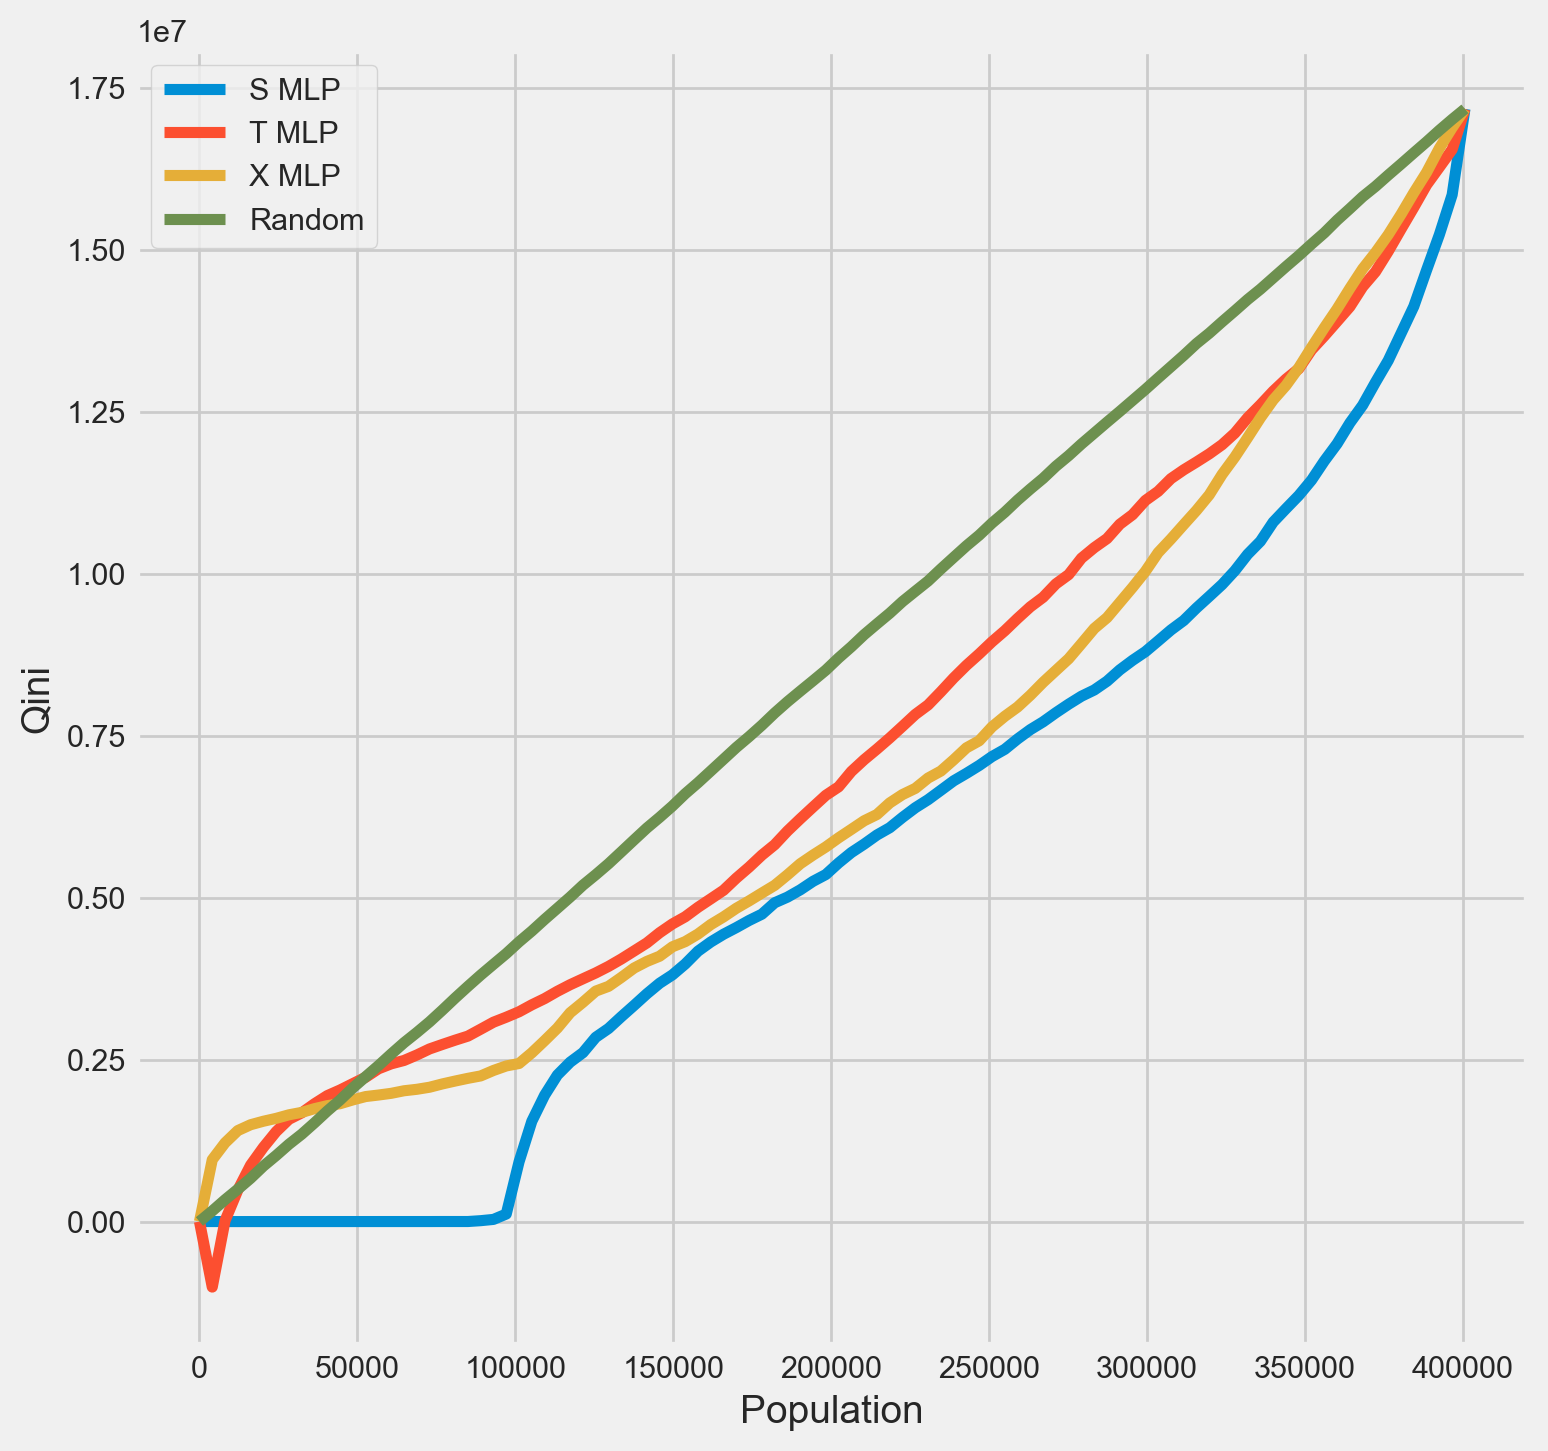

In [71]:
plot_qini(df_preds_mlp)

### CTS

In [45]:
from causalml.inference.tree import CausalRandomForestRegressor, CausalTreeRegressor

In [74]:
from causalml.inference.tree import CausalRandomForestRegressor, CausalTreeRegressor

best_params['CTS'] = {'max_depth': 0}
best_qini = 0
with tqdm(total=4) as pbar:
    for max_depth in [5, 10, 20, 40]:
        ctree = CausalTreeRegressor(max_depth=max_depth)
        cate_tree = ctree.fit_predict(X=X, y=y.values, treatment=treatment.values)
        df_preds_cts = pd.DataFrame([
                           cate_tree.ravel(),
                           treatment.ravel(),
                           y.ravel()],
                           index=['CTS','w','y']).T
        cur_qini = get_qini(df_preds_cts).sum(axis=0)['CTS']
        if cur_qini > best_qini:
            best_params['CTS']['max_depth'] = max_depth
            best_qini = cur_qini
        pbar.update(1)


                
print('Best parameters for CTS:')
print(best_params['CTS'])

100%|████████████████████████████████████████████| 4/4 [23:30<00:00, 352.52s/it]

Best parameters for CTS:
{'max_depth': 40}


In [50]:
best_params['CTS_forest'] = {'max_depth': 0, 'n_estimators': 0}
best_qini = 0
with tqdm(total=12) as pbar:
    for max_depth in [5, 10, 20, 40]:
        for n_estimators in [10, 20, 40]:
            cforest = CausalRandomForestRegressor(max_depth = max_depth, n_estimators=n_estimators, n_jobs=5)
            #cateаforest = cforest.fit_predict(X=X, y=y.values, treatment=treatment.values)
            cate_forest = cforest.fit(X=X, y=y.values, treatment=treatment.values).predict(X=X)
            df_preds_forest = pd.DataFrame([
                               cate_forest.ravel(),
                               treatment.ravel(),
                               y.ravel()],
                               index=['CTS_forest','w','y']).T
            cur_qini = get_qini(df_preds_forest).sum(axis=0)['CTS_forest']
            if cur_qini > best_qini:
                best_params['CTS_forest']['max_depth'] = max_depth
                best_params['CTS_forest']['n_estimators'] = n_estimators
                best_qini = cur_qini
            pbar.update(1)


                
print('Best parameters for CTS_forest:')
print(best_params['CTS_forest'])

100%|███████████████████████████████████████| 12/12 [6:52:59<00:00, 2064.94s/it]

Best parameters for CTS:


KeyError: 'CTS'

In [51]:
print(best_params['CTS_forest'])

{'max_depth': 20, 'n_estimators': 10}


In [56]:
best_params

{'CTS_forest': {'max_depth': 20, 'n_estimators': 10}, 'CTS': {'max_depth': 40}}

In [57]:
ctree = CausalTreeRegressor(max_depth=best_params['CTS']['max_depth'])
cate_tree = ctree.fit_predict(X=X, y=y.values, treatment=treatment.values)

print('CTS fitted')

cforest = CausalRandomForestRegressor(max_depth = best_params['CTS_forest']['max_depth'], n_estimators=best_params['CTS_forest']['n_estimators'], n_jobs=5)
cate_forest = cforest.fit(X=X, y=y.values, treatment=treatment.values).predict(X=X)

print('CTS_forest is fitted')

CTS fitted
CTS_forest is fitted


In [60]:
df_preds_cts = pd.DataFrame([  cate_tree.ravel(),
                               cate_forest.ravel(),
                               treatment.ravel(),
                               y.ravel()],
                               index=['CTS','CTS forest','w','y']).T

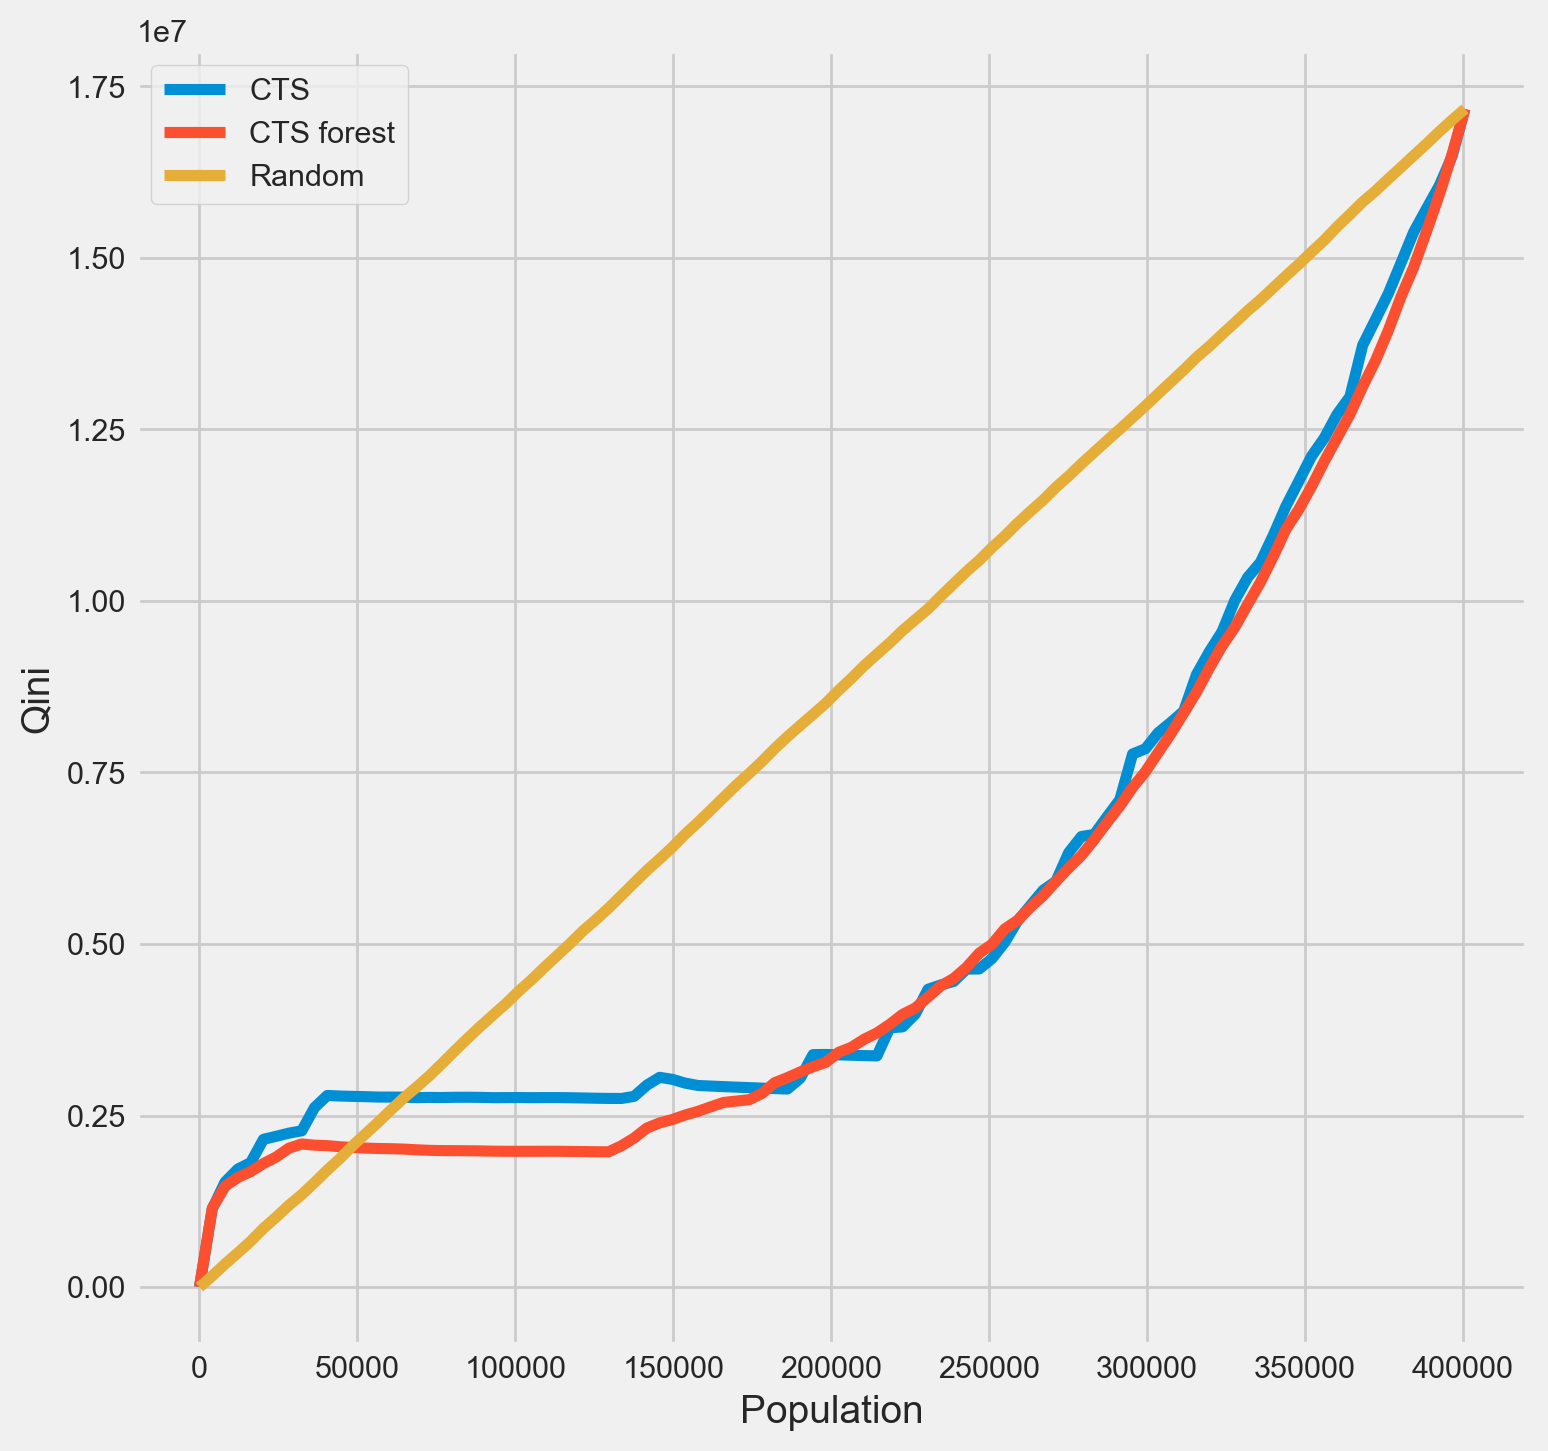

In [61]:
plot_qini(df_preds_cts)

## EconML

In [ ]:
!pip install econml

In [65]:
import econml
from econml.metalearners import SLearner
from econml.metalearners import TLearner
from econml.metalearners import XLearner

In [66]:
best_params_econml = {}

In [75]:
# S Learner with XGBoost searching hyperparameters

best_params_econml['S_XGBoost'] = {'n_estimators': 0, 'max_depth': 0, 'lr': 0}
best_qini = 0
with tqdm(total=27) as pbar:
    for n_estimators in [200, 400, 600]:
        for max_depth in [20, 40, 60]:
            for lr in [1e-3, 1e-2, 1e-1]:
                learner_s_xgboost = SLearner(overall_model=XGBRegressor(n_estimators = n_estimators, 
                                                                        max_depth = max_depth, 
                                                                        learning_rate = lr, gpu_id=1))
                learner_s_xgboost.fit(X=X, T=treatment, Y=y)
                cate_s_xgboost = learner_s_xgboost.effect(X)
                df_preds_xgboost = pd.DataFrame([
                                   cate_s_xgboost.ravel(),
                                   treatment.ravel(),
                                   y.ravel()],
                                   index=['S Xgboost','w','y']).T
                cur_qini = get_qini(df_preds_xgboost).sum(axis=0)['S Xgboost']
                if cur_qini > best_qini:
                    best_params_econml['S_XGBoost']['n_estimators'] = n_estimators
                    best_params_econml['S_XGBoost']['max_depth'] = max_depth
                    best_params_econml['S_XGBoost']['lr'] = lr
                    best_qini = cur_qini
                pbar.update(1)


                
print('Best parameters for S_XGBoost:')
print(best_params_econml['S_XGBoost'])

100%|████████████████████████████████████████| 27/27 [1:16:44<00:00, 170.54s/it]

Best parameters for S_XGBoost:
{'n_estimators': 600, 'max_depth': 60, 'lr': 0.01}


In [79]:
# T Learner with XGBoost searching hyperparameters

best_params_econml['T_XGBoost'] = {'n_estimators': 0, 'max_depth': 0, 'lr': 0}
best_qini = 0
with tqdm(total=27) as pbar:
    for n_estimators in [200, 400, 600]:
        for max_depth in [20, 40, 60]:
            for lr in [1e-3, 1e-2, 1e-1]:
                learner_t_xgboost = TLearner(models=XGBRegressor(n_estimators = n_estimators, 
                                                                        max_depth = max_depth, 
                                                                        learning_rate = lr, gpu_id=1))
                learner_t_xgboost.fit(X=X, T=treatment, Y=y)
                cate_t_xgboost = learner_t_xgboost.effect(X)
                df_preds_xgboost = pd.DataFrame([
                                   cate_t_xgboost.ravel(),
                                   treatment.ravel(),
                                   y.ravel()],
                                   index=['T Xgboost','w','y']).T
                cur_qini = get_qini(df_preds_xgboost).sum(axis=0)['T Xgboost']
                if cur_qini > best_qini:
                    best_params_econml['T_XGBoost']['n_estimators'] = n_estimators
                    best_params_econml['T_XGBoost']['max_depth'] = max_depth
                    best_params_econml['T_XGBoost']['lr'] = lr
                    best_qini = cur_qini
                pbar.update(1)


                
print('Best parameters for T_XGBoost:')
print(best_params_econml['T_XGBoost'])

100%|████████████████████████████████████████| 27/27 [1:13:05<00:00, 162.43s/it]

Best parameters for T_XGBoost:
{'n_estimators': 400, 'max_depth': 40, 'lr': 0.01}


In [80]:
# X Learner with XGBoost searching hyperparameters

best_params_econml['X_XGBoost'] = {'n_estimators': 0, 'max_depth': 0, 'lr': 0}
best_qini = 0
with tqdm(total=27) as pbar:
    for n_estimators in [200, 400, 600]:
        for max_depth in [20, 40, 60]:
            for lr in [1e-3, 1e-2, 1e-1]:
                learner_x_xgboost = XLearner(models=XGBRegressor(n_estimators = n_estimators, 
                                                                        max_depth = max_depth, 
                                                                        learning_rate = lr, gpu_id=1))
                learner_x_xgboost.fit(X=X, T=treatment, Y=y)
                cate_x_xgboost = learner_x_xgboost.effect(X)
                df_preds_xgboost = pd.DataFrame([
                                   cate_x_xgboost.ravel(),
                                   treatment.ravel(),
                                   y.ravel()],
                                   index=['X Xgboost','w','y']).T
                cur_qini = get_qini(df_preds_xgboost).sum(axis=0)['X Xgboost']
                if cur_qini > best_qini:
                    best_params_econml['X_XGBoost']['n_estimators'] = n_estimators
                    best_params_econml['X_XGBoost']['max_depth'] = max_depth
                    best_params_econml['X_XGBoost']['lr'] = lr
                    best_qini = cur_qini
                pbar.update(1)


                
print('Best parameters for X_XGBoost:')
print(best_params_econml['X_XGBoost'])

100%|████████████████████████████████████████| 27/27 [2:29:31<00:00, 332.29s/it]

Best parameters for X_XGBoost:
{'n_estimators': 200, 'max_depth': 40, 'lr': 0.01}


In [81]:
best_params_econml

{'S_XGBoost': {'n_estimators': 600, 'max_depth': 60, 'lr': 0.01},
 'T_XGBoost': {'n_estimators': 400, 'max_depth': 40, 'lr': 0.01},
 'X_XGBoost': {'n_estimators': 200, 'max_depth': 40, 'lr': 0.01}}

In [83]:
learner_s_xgboost = SLearner(overall_model=XGBRegressor(n_estimators = best_params_econml['S_XGBoost']['n_estimators'], 
                                                        max_depth = best_params_econml['S_XGBoost']['max_depth'], 
                                                        learning_rate = best_params_econml['S_XGBoost']['lr'], gpu_id=1))
learner_s_xgboost.fit(X=X, T=treatment, Y=y)
cate_s_xgboost = learner_s_xgboost.effect(X)

print('S learner is fitted')


learner_t_xgboost = TLearner(models=XGBRegressor(n_estimators = best_params_econml['T_XGBoost']['n_estimators'], 
                                                max_depth = best_params_econml['T_XGBoost']['max_depth'], 
                                                learning_rate = best_params_econml['T_XGBoost']['lr'], gpu_id=1))
learner_t_xgboost.fit(X=X, T=treatment, Y=y)
cate_t_xgboost = learner_t_xgboost.effect(X)

print('T learner is fitted')

learner_x_xgboost = XLearner(models=XGBRegressor(n_estimators = best_params_econml['X_XGBoost']['n_estimators'], 
                                                max_depth = best_params_econml['X_XGBoost']['max_depth'], 
                                                learning_rate = best_params_econml['X_XGBoost']['lr'], gpu_id=1))
learner_x_xgboost.fit(X=X, T=treatment, Y=y)
cate_x_xgboost = learner_x_xgboost.effect(X)

print('X learner is fitted')

S learner is fitted
T learner is fitted
X learner is fitted


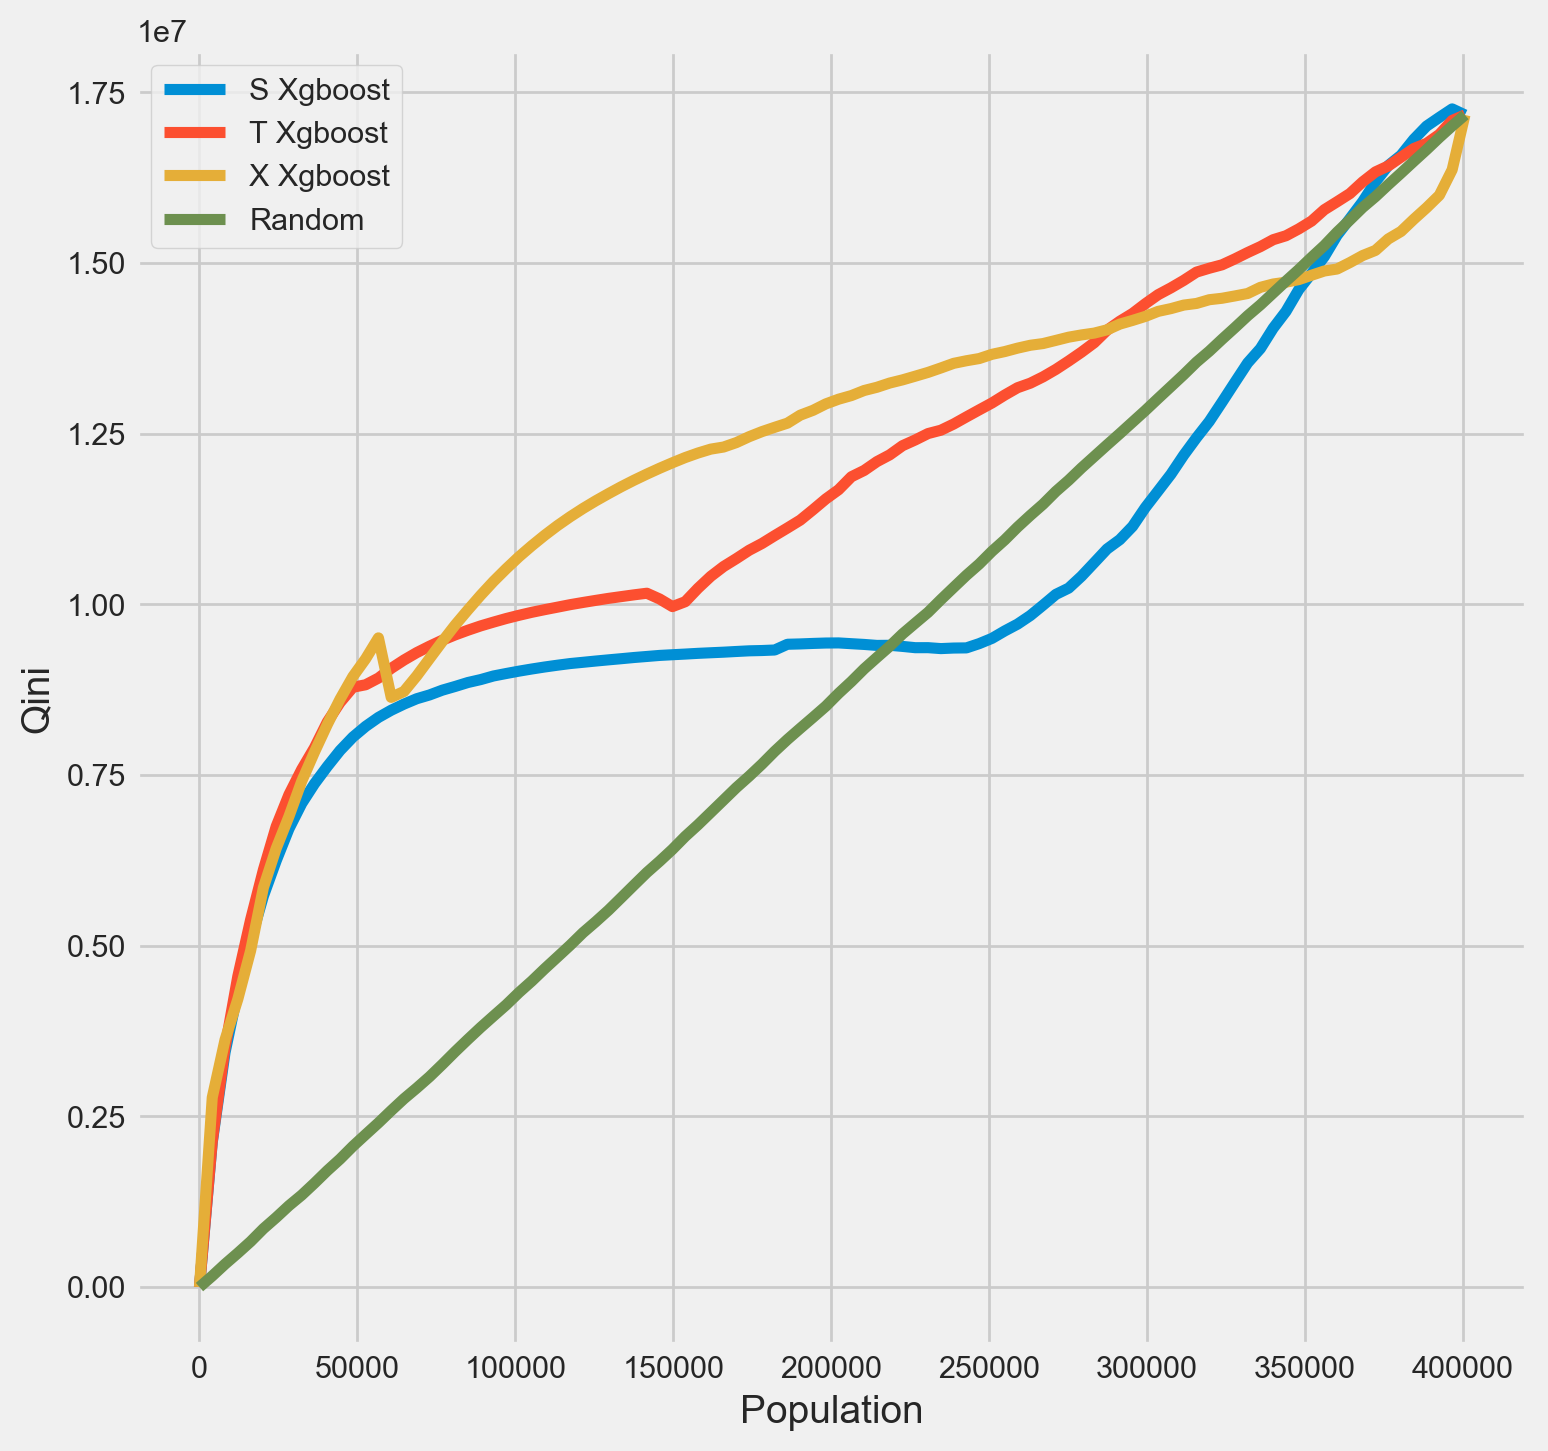

In [84]:
df_preds_xgboost = pd.DataFrame([
                   cate_s_xgboost.ravel(),
                   cate_t_xgboost.ravel(),
                   cate_x_xgboost.ravel(),
                   treatment.ravel(),
                   y.ravel()],
                   index=['S Xgboost', 'T Xgboost','X Xgboost','w','y']).T

plot_qini(df_preds_xgboost)

### MLP

In [87]:
from sklearn.neural_network import MLPRegressor

# S Learner with MLP searching hyperparameters

best_params_econml['S_MLP'] = {'hls': []}
best_qini = 0
with tqdm(total=6) as pbar:
    for hls in [[100], [100, 100], [200], [200, 200], [300], [300, 300]]:
        learner_s_mlp = SLearner(overall_model=MLPRegressor(hidden_layer_sizes = hls))    
        learner_s_mlp.fit(X=X, T=treatment, Y=y)
        cate_s_mlp = learner_s_mlp.effect(X)

        df_preds_mlp = pd.DataFrame([
                           cate_s_mlp.ravel(),
                           treatment.ravel(),
                           y.ravel()],
                           index=['S MLP','w','y']).T
        cur_qini = get_qini(df_preds_mlp).sum(axis=0)['S MLP']
        if cur_qini > best_qini:
            best_params_econml['S_MLP']['hls'] = hls
            best_qini = cur_qini
        pbar.update(1)


                
print('Best parameters for S_MLP:')
print(best_params_econml['S_MLP'])

100%|████████████████████████████████████████████| 6/6 [43:05<00:00, 430.86s/it]

Best parameters for S_MLP:
{'hls': [300, 300]}


In [88]:
best_params_econml['T_MLP'] = {'hls': []}
best_qini = 0
with tqdm(total=6) as pbar:
    for hls in [[100], [100, 100], [200], [200, 200], [300], [300, 300]]:
        learner_t_mlp = TLearner(models=MLPRegressor(hidden_layer_sizes = hls))    
        learner_t_mlp.fit(X=X, T=treatment, Y=y)
        cate_t_mlp = learner_t_mlp.effect(X)

        df_preds_mlp = pd.DataFrame([
                           cate_t_mlp.ravel(),
                           treatment.ravel(),
                           y.ravel()],
                           index=['T MLP','w','y']).T
        cur_qini = get_qini(df_preds_mlp).sum(axis=0)['T MLP']
        if cur_qini > best_qini:
            best_params_econml['T_MLP']['hls'] = hls
            best_qini = cur_qini
        pbar.update(1)


                
print('Best parameters for T_MLP:')
print(best_params_econml['T_MLP'])

100%|████████████████████████████████████████████| 6/6 [36:47<00:00, 367.99s/it]

Best parameters for T_MLP:
{'hls': [100]}


In [89]:
best_params_econml['X_MLP'] = {'hls': []}
best_qini = 0
with tqdm(total=6) as pbar:
    for hls in [[100], [100, 100], [200], [200, 200], [300], [300, 300]]:
        learner_x_mlp = XLearner(models=MLPRegressor(hidden_layer_sizes = hls))    
        learner_x_mlp.fit(X=X, T=treatment, Y=y)
        cate_x_mlp = learner_x_mlp.effect(X)

        df_preds_mlp = pd.DataFrame([
                           cate_x_mlp.ravel(),
                           treatment.ravel(),
                           y.ravel()],
                           index=['X MLP','w','y']).T
        cur_qini = get_qini(df_preds_mlp).sum(axis=0)['X MLP']
        if cur_qini > best_qini:
            best_params_econml['X_MLP']['hls'] = hls
            best_qini = cur_qini
        pbar.update(1)


                
print('Best parameters for X_MLP:')
print(best_params_econml['X_MLP'])

100%|██████████████████████████████████████████| 6/6 [1:21:18<00:00, 813.03s/it]

Best parameters for X_MLP:
{'hls': [300, 300]}


In [90]:
# S Learner on MLP

learner_s_mlp = SLearner(overall_model=MLPRegressor(hidden_layer_sizes = best_params_econml['S_MLP']['hls']))    
learner_s_mlp.fit(X=X, T=treatment, Y=y)
cate_s_mlp = learner_s_mlp.effect(X)

print('S Learner is fitted')

# T Learner on MLP

learner_t_mlp = TLearner(models=MLPRegressor(hidden_layer_sizes = best_params_econml['T_MLP']['hls']))    
learner_t_mlp.fit(X=X, T=treatment, Y=y)
cate_t_mlp = learner_t_mlp.effect(X)

print('T Learner is fitted')

# X Learner on MLP

learner_x_mlp = XLearner(models=MLPRegressor(hidden_layer_sizes = best_params_econml['X_MLP']['hls']))    
learner_x_mlp.fit(X=X, T=treatment, Y=y)
cate_x_mlp = learner_x_mlp.effect(X)

print('X Learner is fitted')

S Learner is fitted
T Learner is fitted
X Learner is fitted


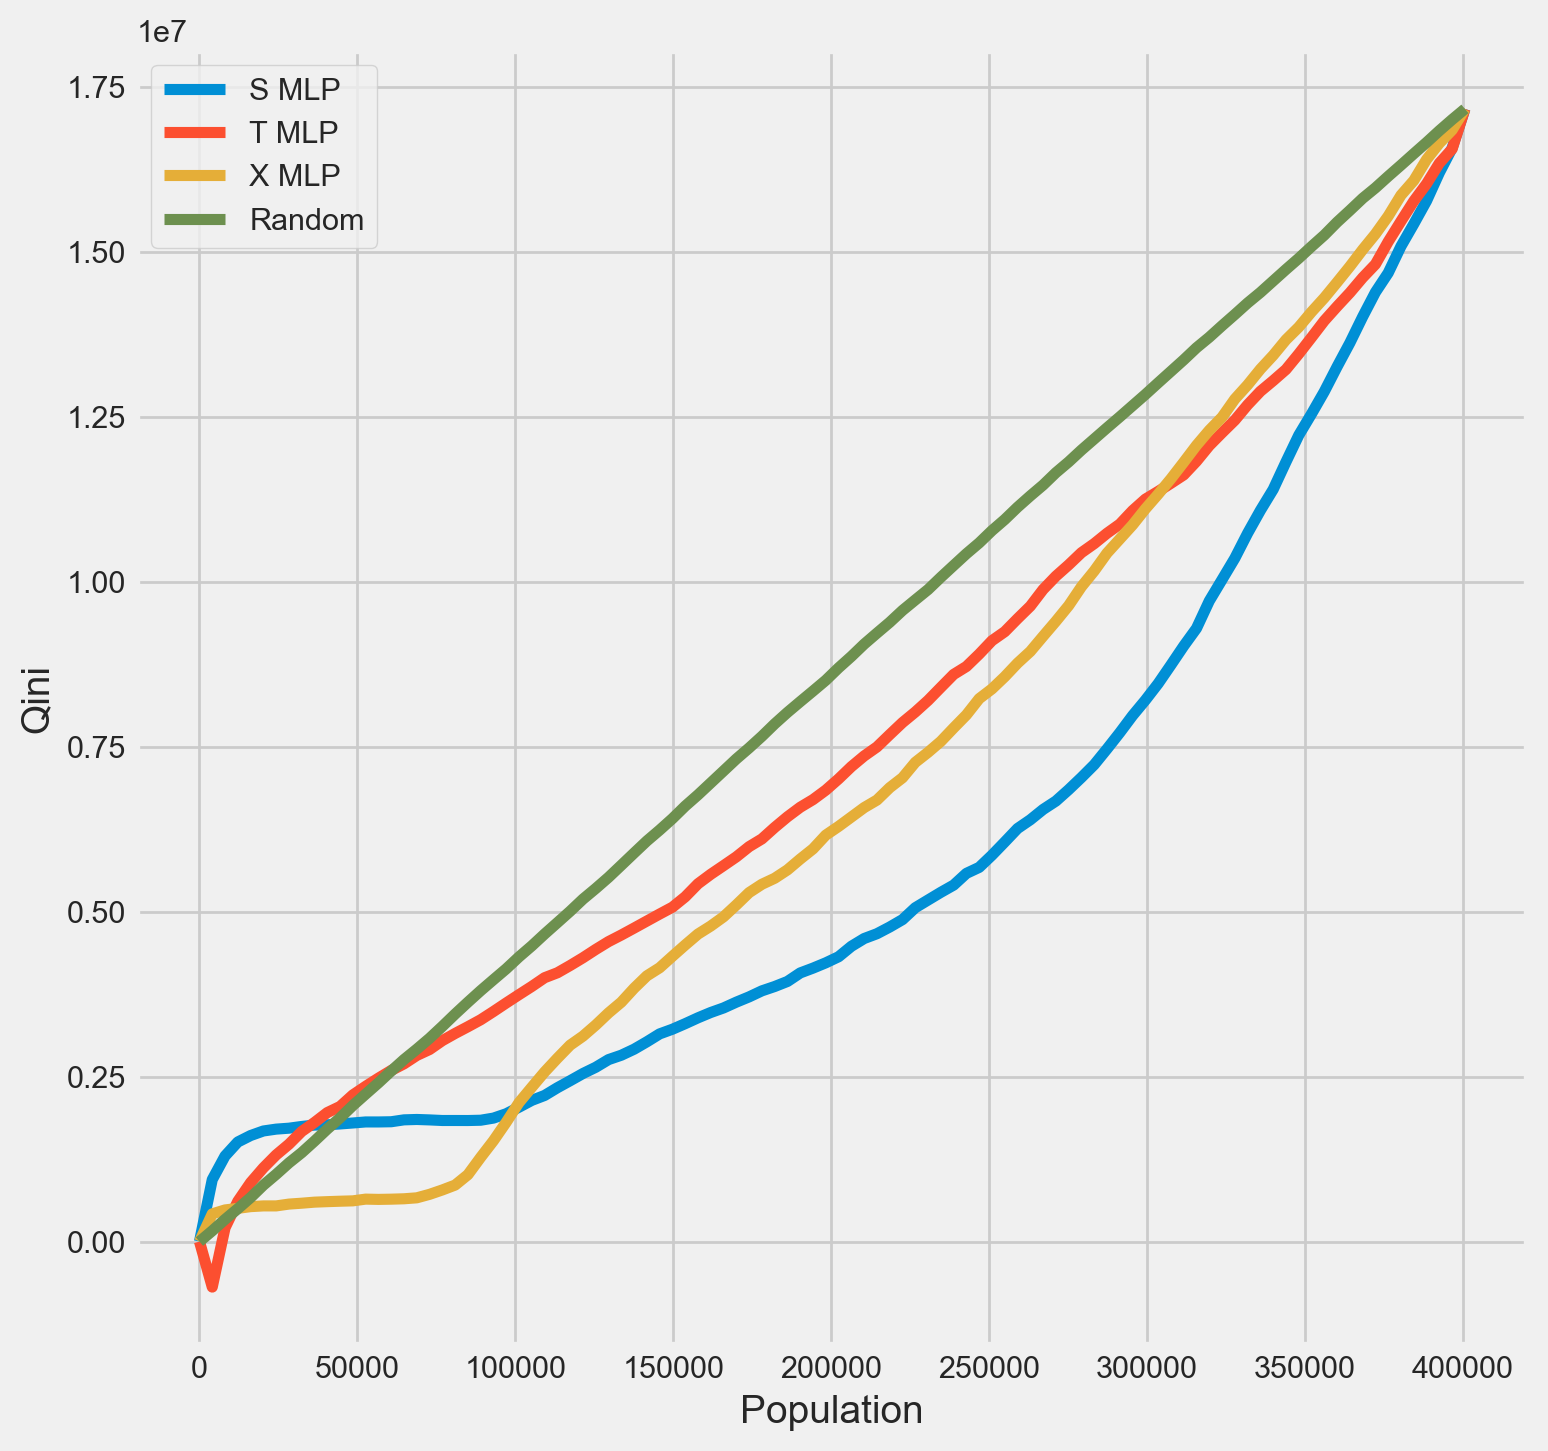

In [91]:
df_preds_mlp = pd.DataFrame([
                   cate_s_mlp.ravel(),
                   cate_t_mlp.ravel(),
                   cate_x_mlp.ravel(),
                   treatment.ravel(),
                   y.ravel()],
                   index=['S MLP', 'T MLP','X MLP','w','y']).T

plot_qini(df_preds_mlp)

In [92]:
best_params_econml

{'S_XGBoost': {'n_estimators': 600, 'max_depth': 60, 'lr': 0.01},
 'T_XGBoost': {'n_estimators': 400, 'max_depth': 40, 'lr': 0.01},
 'X_XGBoost': {'n_estimators': 200, 'max_depth': 40, 'lr': 0.01},
 'S_MLP': {'hls': [300, 300]},
 'T_MLP': {'hls': [100]},
 'X_MLP': {'hls': [300, 300]}}

In [ ]:
### CTS

In [ ]:
from econml.grf import CausalForest
